In [43]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pokemon-challenge/pokemon.csv
/kaggle/input/pokemon-challenge/tests.csv
/kaggle/input/pokemon-challenge/combats.csv


# 🧬 Pokémon Battle Dataset Analysis

## 📚 Dataset Description

This dataset represents simulated **Pokémon battles**. Each record corresponds to a single combat between two Pokémon and includes information about each Pokémon's:

- **Base Stats:**
  - `HP`, `Attack`, `Defense`, `Sp. Atk`, `Sp. Def`, `Speed`
- **Type Information:**
  - `Type 1` and (if available) `Type 2`
- **Metadata:**
  - `Generation`, `Legendary Status`
- **Outcome:**
  - `Winner` (binary target indicating whether the first or second Pokémon won)

All stats and metadata are duplicated for both the `First_` and `Second_` Pokémon in the battle.

---




### 📁 Step 1: Importing the Data

In the first step, we import two key datasets:

- **Pokémon Dataset**: Contains general information about each Pokémon, including stats (HP, Attack, Defense, etc.), type classifications, generation, and whether it's legendary.
- **Combat Dataset**: Represents battle outcomes. Each row consists of two Pokémon IDs and indicates which Pokémon won the fight.

These datasets will later be **merged** based on Pokémon IDs to create a comprehensive combat record with all relevant attributes.


In [44]:
import pandas as pd

# Load the datasets
pokemon_df = pd.read_csv('/kaggle/input/pokemon-challenge/pokemon.csv')
combats_df = pd.read_csv('/kaggle/input/pokemon-challenge/combats.csv')

# Show first few rows
print("Pokemon Dataset:")
display(pokemon_df.head())

print("\nCombats Dataset:")
display(combats_df.head())


Pokemon Dataset:


#           Name Type 1  Type 2  HP  Attack  Defense  Sp. Atk  Sp. Def  \
0  1      Bulbasaur  Grass  Poison  45      49       49       65       65   
1  2        Ivysaur  Grass  Poison  60      62       63       80       80   
2  3       Venusaur  Grass  Poison  80      82       83      100      100   
3  4  Mega Venusaur  Grass  Poison  80     100      123      122      120   
4  5     Charmander   Fire     NaN  39      52       43       60       50   

   Speed  Generation  Legendary  
0     45           1      False  
1     60           1      False  
2     80           1      False  
3     80           1      False  
4     65           1      False


Combats Dataset:


First_pokemon  Second_pokemon  Winner
0            266             298     298
1            702             701     701
2            191             668     668
3            237             683     683
4            151             231     151

### 🔍 Checking for Missing Values in Pokémon Dataset

 #### Looks like for some pokemons that do not have second type we have missing values

In [45]:
pokemon_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        799 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   HP          800 non-null    int64 
 5   Attack      800 non-null    int64 
 6   Defense     800 non-null    int64 
 7   Sp. Atk     800 non-null    int64 
 8   Sp. Def     800 non-null    int64 
 9   Speed       800 non-null    int64 
 10  Generation  800 non-null    int64 
 11  Legendary   800 non-null    bool  
dtypes: bool(1), int64(8), object(3)
memory usage: 69.7+ KB


Also there is one row that has null name let's drop it.

In [46]:
pokemon_df = pokemon_df.dropna(subset=['Name'])

### Distribution of Pokémon Types

To understand the overall composition of Pokémon in the dataset, we explore how the primary and secondary types are distributed. This helps us identify the most common and rare types, providing insights into potential class imbalances or dominant traits.

By plotting the distributions of `Type 1` and `Type 2`, we can visualize the frequency of each elemental type among all Pokémon. This step is crucial  understanding potential type advantages in battles.


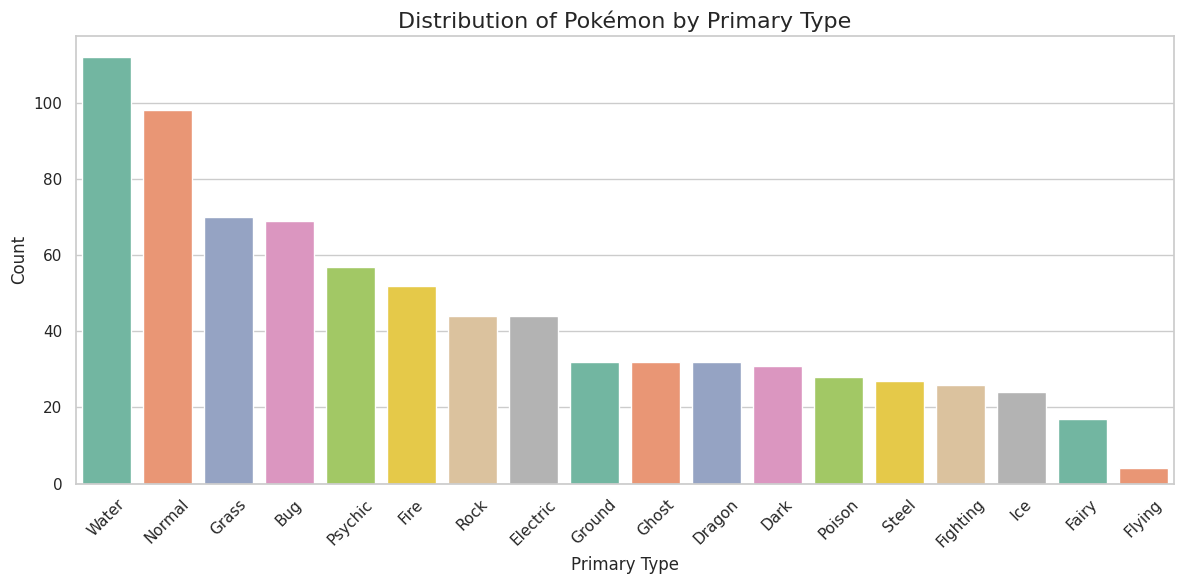

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
plt.figure(figsize=(12,6))
sns.set_style("whitegrid")

# Countplot of Type 1
sns.countplot(data=pokemon_df, x='Type 1', order=pokemon_df['Type 1'].value_counts().index, palette="Set2")

# Add titles and labels
plt.title('Distribution of Pokémon by Primary Type', fontsize=16)
plt.xlabel('Primary Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Having flying the most makes sense because most of the flying pokemons have to have this second type whereas the pokemons stay on the gorund do not have a special secondary type

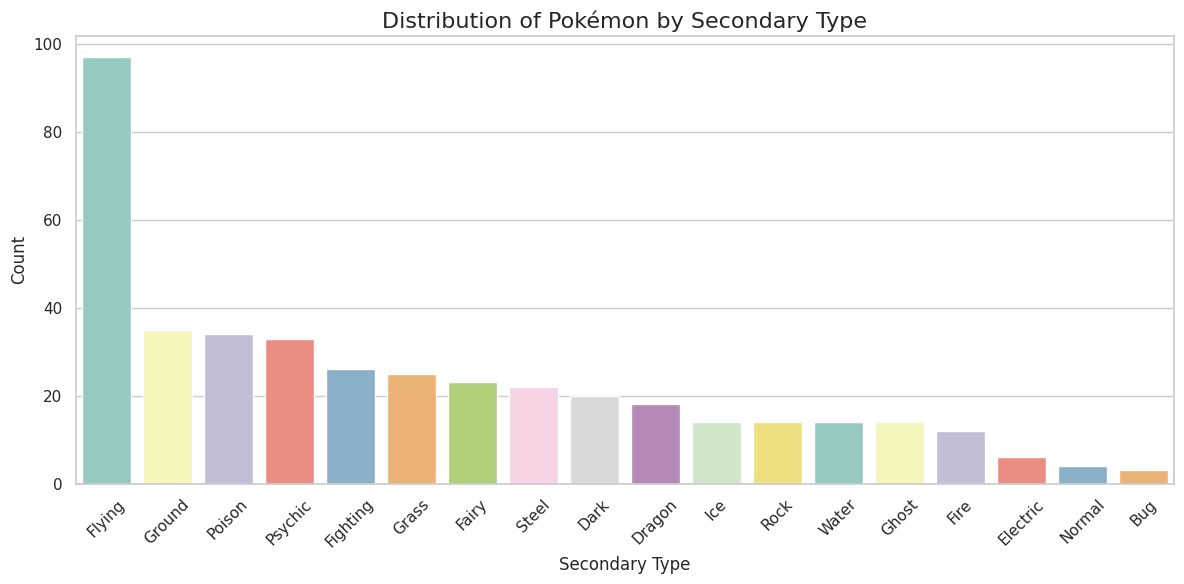

In [48]:
# Set plot size and style
plt.figure(figsize=(12,6))
sns.set_style("whitegrid")

# Countplot of Type 2 (excluding nulls for better clarity)
sns.countplot(data=pokemon_df[~pokemon_df['Type 2'].isnull()], 
              x='Type 2', 
              order=pokemon_df['Type 2'].value_counts().index,
              palette="Set3")

# Add titles and labels
plt.title('Distribution of Pokémon by Secondary Type', fontsize=16)
plt.xlabel('Secondary Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Distribution of Base Stats and Attributes

Next, we examine the distribution of core attributes such as HP, Attack, Defense, Special Attack, Special Defense, and Speed. Understanding how these base stats are distributed helps in identifying outliers, skewness, and the general power levels of Pokémon.




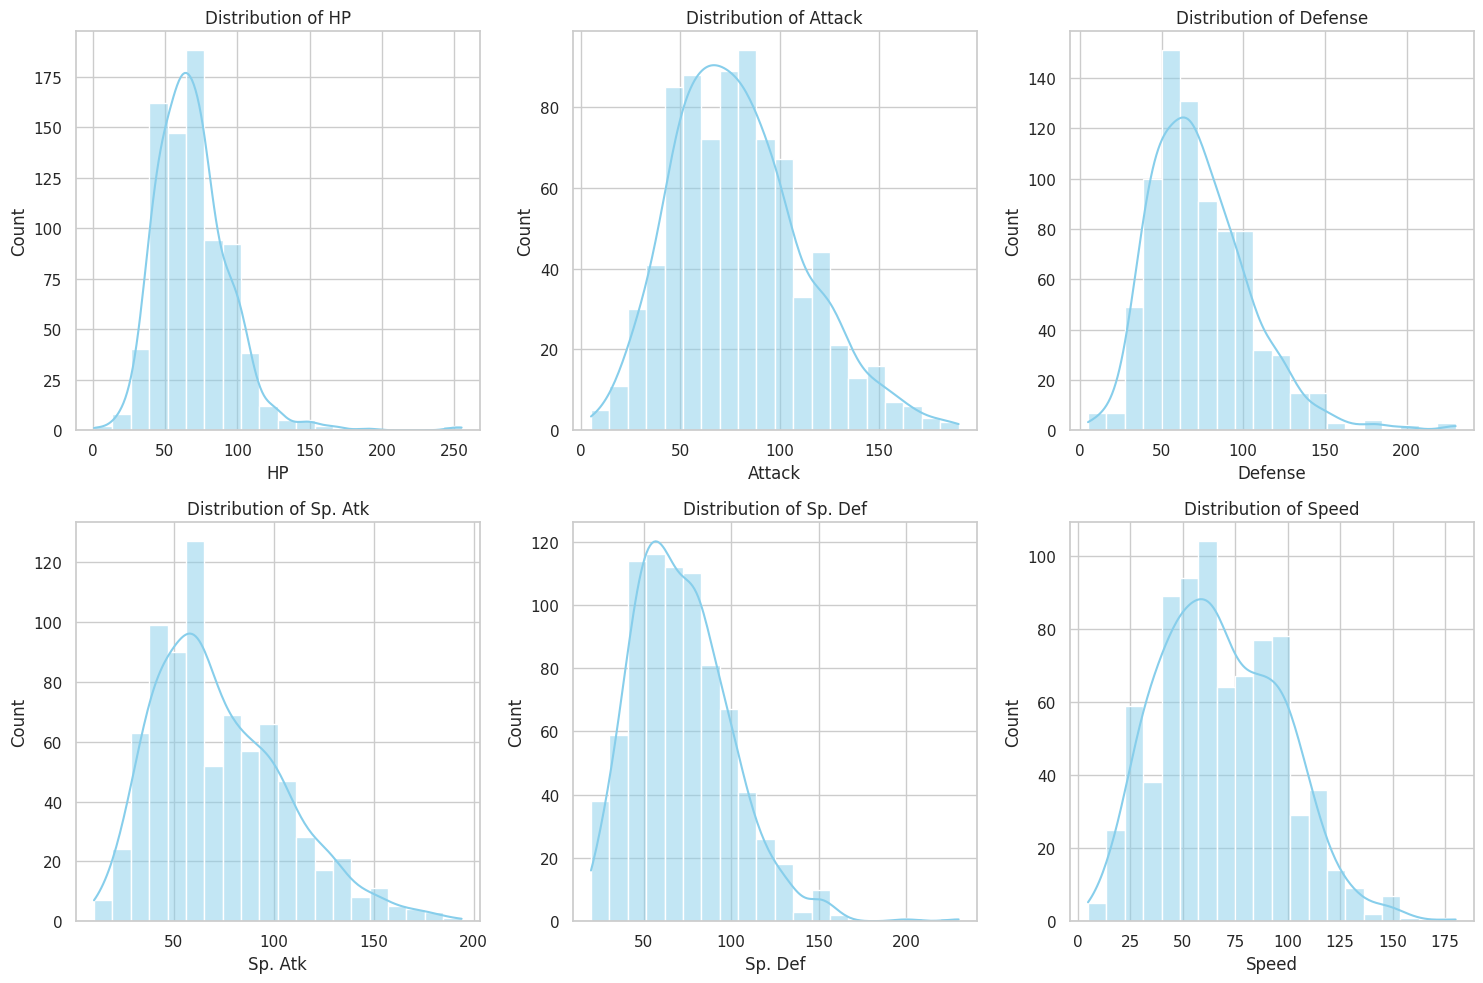

In [49]:
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings

# List of numerical stat columns
stat_cols = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']

# Set up the figure
plt.figure(figsize=(15, 10))
sns.set_style("whitegrid")

# Loop through each stat column
for i, col in enumerate(stat_cols):
    plt.subplot(2, 3, i+1)
    sns.histplot(pokemon_df[col], kde=True, bins=20, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()


### Correlation Heatmap of Base Stats

We then inspect the correlation heatmap of Pokémon attributes to understand how different stats relate to one another. Several insights can be drawn from the heatmap:

- **Attack vs. Defense**: There is a moderate positive correlation between Attack and Defense. This suggests that stronger offensive Pokémon tend to also be sturdier, possibly due to overall higher base stats.
  
- **Speed Relationships**: Speed tends to correlate positively with Attack but negatively with HP and Defense. This implies that faster Pokémon often focus on high-damage output rather than tankiness.

- **Legendary Status**: Being a Legendary Pokémon is positively correlated with higher Attack and other base stats, confirming that legendary status is generally associated with stronger attributes.

These correlations help guide feature selection and give us a better sense of the game's design logic.


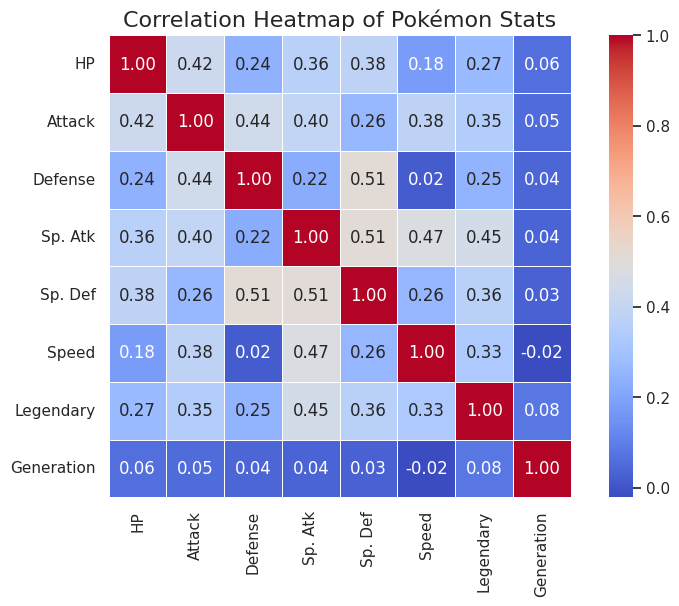

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Select only the numerical stat columns
stat_cols = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed','Legendary','Generation']
stats_df = pokemon_df[stat_cols]

# Compute the correlation matrix
corr_matrix = stats_df.corr()

# Set up the heatmap
plt.figure(figsize=(10, 6))
sns.set(style="white")

# Draw the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f", square=True)

# Add title
plt.title('Correlation Heatmap of Pokémon Stats', fontsize=16)
plt.show()


### Distribution of Legendary Pokémon

We now examine the distribution of the `Legendary` attribute in the dataset. This feature indicates whether a Pokémon is classified as Legendary or not.

Understanding this distribution is important because Legendary Pokémon often possess significantly higher stats, which can impact battle outcomes and model performance.

A quick visualization reveals that **Legendary Pokémon make up only a small portion of the dataset**, indicating a class imbalance. This rarity aligns with the game design where Legendary Pokémon are intended to be exceptional and uncommon.


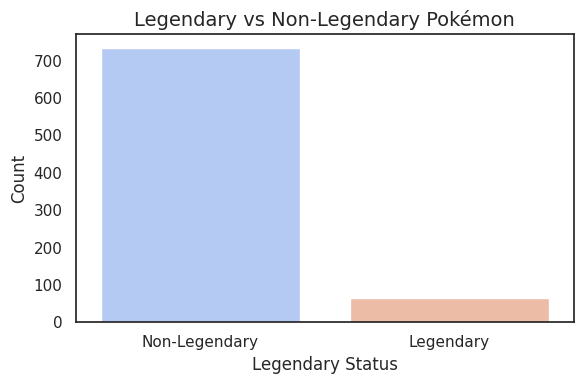

In [51]:
plt.figure(figsize=(6, 4))
sns.countplot(data=pokemon_df, x='Legendary', palette='coolwarm')

plt.title('Legendary vs Non-Legendary Pokémon', fontsize=14)
plt.xlabel('Legendary Status')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-Legendary', 'Legendary'])
plt.tight_layout()
plt.show()

### Generation Distribution

Next, we investigate the distribution of Pokémon across different generations. Each generation corresponds to a major release of the Pokémon games and introduces new Pokémon species.

Understanding the generation distribution helps ensure that the dataset represents a balanced variety of Pokémon from different eras. If certain generations dominate the dataset, it could introduce bias in the model training process.

By plotting the frequency of each generation, we can quickly observe whether the data is evenly spread or skewed towards specific generations.

From the plot, we can see that there is no significant bias toward any single generation, indicating a well-balanced representation of Pokémon across different generations.


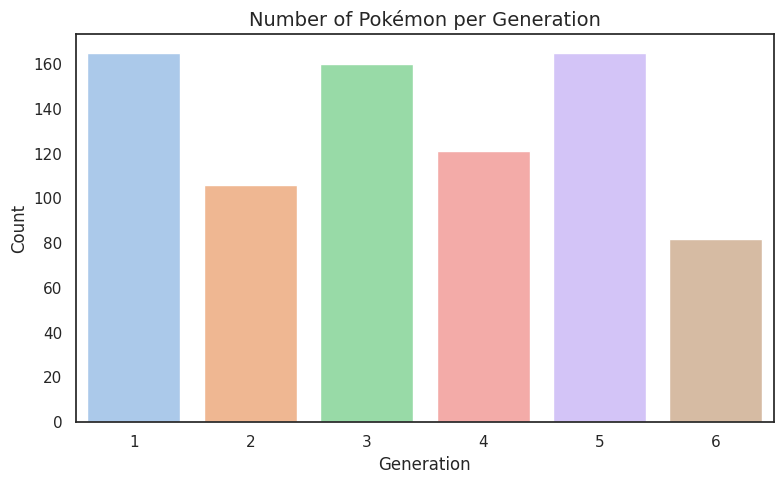

In [52]:
plt.figure(figsize=(8, 5))
sns.countplot(data=pokemon_df, x='Generation', palette='pastel')

plt.title('Number of Pokémon per Generation', fontsize=14)
plt.xlabel('Generation')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

### Do Legendary Pokémon Have Better Stats?

A common question is whether being classified as "Legendary" actually translates into stronger in-game performance, or if it's merely a fan-service designation. 

To explore this, we compare the overall stats of Legendary vs. non-Legendary Pokémon using visualizations such as boxplots.

The results make it clear — Legendary Pokémon consistently exhibit higher stat values across the board. This confirms that the Legendary status is not just symbolic but corresponds to tangible in-game power, reinforcing their rarity and prominence in the Pokémon universe.


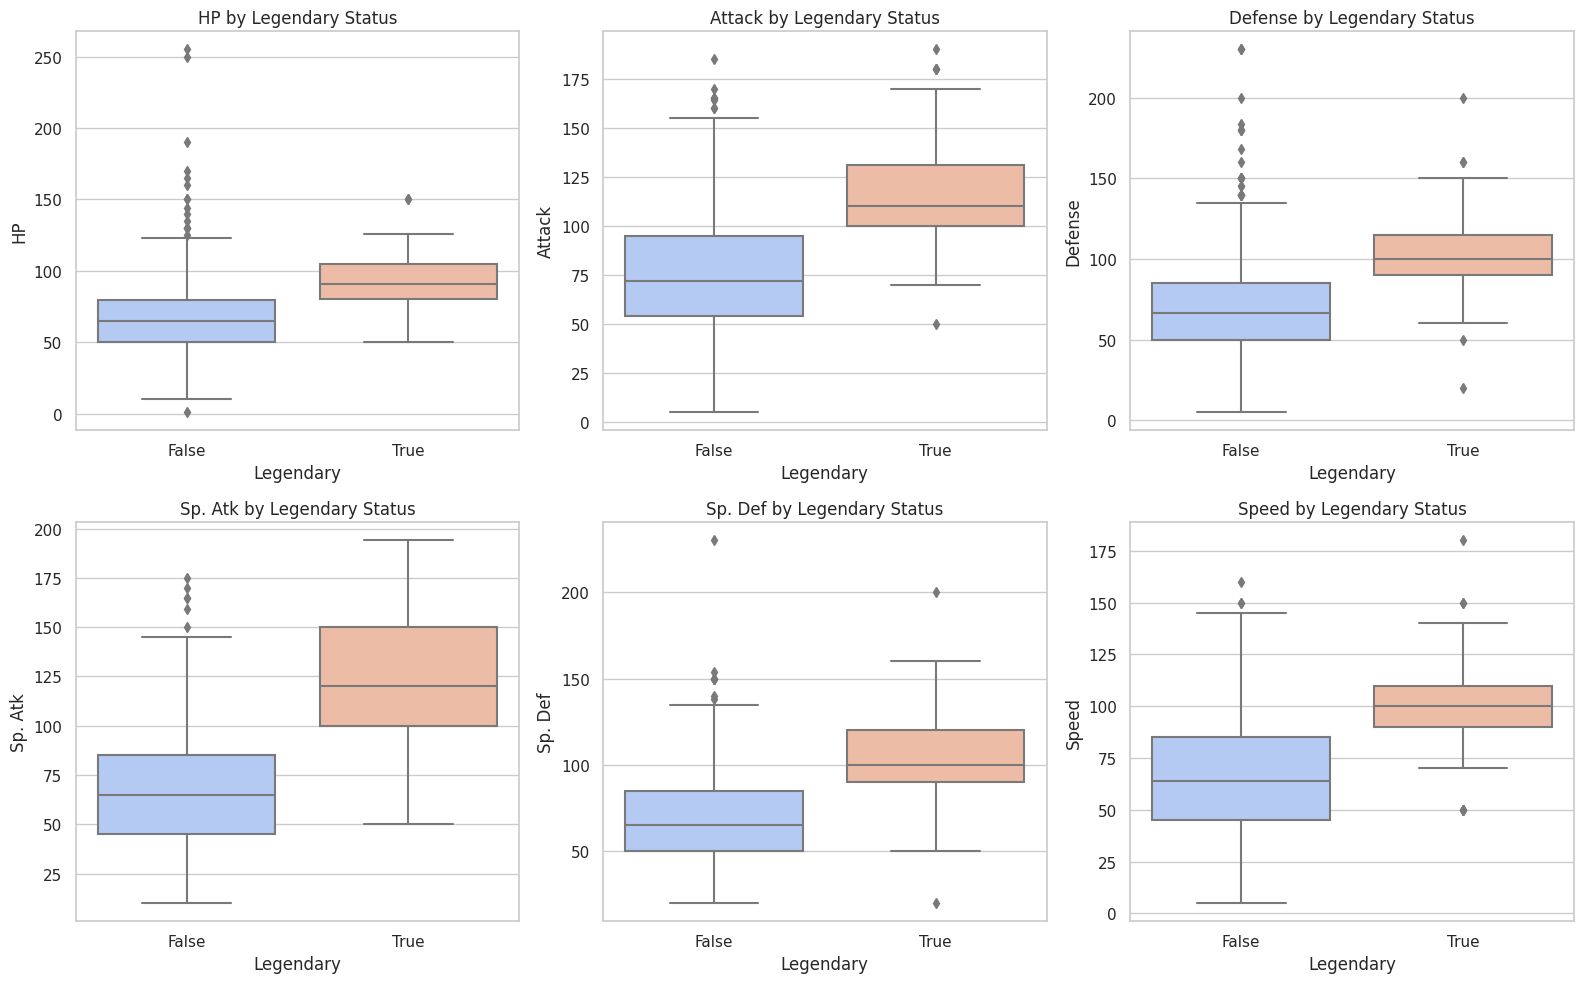

In [53]:
# List of stat columns
stat_cols = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']

# Set plot size
plt.figure(figsize=(16, 10))
sns.set_style("whitegrid")

# Boxplots for each stat grouped by Legendary
for i, col in enumerate(stat_cols):
    plt.subplot(2, 3, i+1)
    sns.boxplot(data=pokemon_df, x='Legendary', y=col, palette='coolwarm')
    plt.title(f'{col} by Legendary Status')
    plt.xlabel('Legendary')
    plt.ylabel(col)

plt.tight_layout()
plt.show()


### Exploring the Combat Dataset

With a general understanding of our Pokémon stats, we now turn to the **combat dataset**. This dataset is straightforward — it contains only three columns:

- `First_pokemon`: The ID of the first Pokémon in the battle.
- `Second_pokemon`: The ID of the second Pokémon.
- `Winner`: The ID of the Pokémon that won the battle.

Each row represents the outcome of a single Pokémon battle. This dataset will be crucial for supervised learning tasks where we aim to predict battle outcomes based on Pokémon attributes.


In [54]:
combats_df.head()

First_pokemon  Second_pokemon  Winner
0            266             298     298
1            702             701     701
2            191             668     668
3            237             683     683
4            151             231     151

### Preparing for Modeling

Simply inspecting the combat dataset on its own doesn't provide much insight. To perform meaningful analysis and modeling, we need to **merge** the combat dataset with the Pokémon stats dataset. This will allow us to associate each Pokémon in a battle with its corresponding features (like HP, Attack, Speed, etc.).

Once merged, we can begin building and training our **baseline models** to predict battle outcomes based on the characteristics of the competing Pokémon.


In [55]:
import pandas as pd

# Load data
pokemon_df = pd.read_csv('/kaggle/input/pokemon-challenge/pokemon.csv')
combats_df = pd.read_csv('/kaggle/input/pokemon-challenge/combats.csv')

# Rename ID column for clarity
pokemon_df = pokemon_df.rename(columns={'#': 'Pokemon_ID'})

# Merge First Pokémon info
merged_pokemon = combats_df.merge(
    pokemon_df.add_prefix('First_'),
    left_on='First_pokemon',
    right_on='First_Pokemon_ID'
)

# Merge Second Pokémon info
merged_pokemon = merged_pokemon.merge(
    pokemon_df.add_prefix('Second_'),
    left_on='Second_pokemon',
    right_on='Second_Pokemon_ID'
)

# Create binary winner column: 1 if First_pokemon wins, else 0
merged_pokemon['Winner'] = (merged_pokemon['First_pokemon'] == merged_pokemon['Winner']).astype(int)

# Optional: Drop original ID columns if not needed
# merged_pokemon = merged_pokemon.drop(columns=['First_pokemon', 'Second_pokemon'])

# Preview the result
print(f"Len of merged {len(merged_pokemon)}")
print(merged_pokemon.columns)
merged_pokemon.head()


Len of merged 50000
Index(['First_pokemon', 'Second_pokemon', 'Winner', 'First_Pokemon_ID',
       'First_Name', 'First_Type 1', 'First_Type 2', 'First_HP',
       'First_Attack', 'First_Defense', 'First_Sp. Atk', 'First_Sp. Def',
       'First_Speed', 'First_Generation', 'First_Legendary',
       'Second_Pokemon_ID', 'Second_Name', 'Second_Type 1', 'Second_Type 2',
       'Second_HP', 'Second_Attack', 'Second_Defense', 'Second_Sp. Atk',
       'Second_Sp. Def', 'Second_Speed', 'Second_Generation',
       'Second_Legendary'],
      dtype='object')


First_pokemon  Second_pokemon  Winner  First_Pokemon_ID First_Name  \
0            266             298       0               266   Larvitar   
1            702             701       0               702   Virizion   
2            191             668       0               191    Togetic   
3            237             683       0               237     Slugma   
4            151             231       1               151    Omastar   

  First_Type 1 First_Type 2  First_HP  First_Attack  First_Defense  ...  \
0         Rock       Ground        50            64             50  ...   
1        Grass     Fighting        91            90             72  ...   
2        Fairy       Flying        55            40             85  ...   
3         Fire          NaN        40            40             40  ...   
4         Rock        Water        70            60            125  ...   

   Second_Type 1  Second_Type 2  Second_HP  Second_Attack  Second_Defense  \
0          Grass           Dark         70             70              40   
1           Rock       Fighting         91            129              90   
2        Psychic            NaN         75             75              75   
3         Dragon            NaN         77            120              90   
4            Bug           Rock         20             10             230   

   Second_Sp. Atk Second_Sp. Def Second_Speed Second_Generation  \
0              60             40           60                 3   
1              72             90          108                 5   
2             125             95           40                 5   
3              60             90           48                 5   
4              10            230            5                 2   

   Second_Legendary  
0             False  
1              True  
2             False  
3             False  
4             False  

[5 rows x 27 columns]

### Exploring Type Advantages

One of the key aspects of Pokémon battles is **type effectiveness**. For example, we expect Water types to have an advantage over Fire types. To validate whether these expected advantages hold true in our dataset, we analyze the **win rates** when two types go head-to-head.

We visualize this using a **heatmap** that shows how often Pokémon of one type win against another.

Interestingly, we observe that **Water types have a lower win rate against Fire types**, which goes against the typical game mechanics. This unexpected result prompts further investigation to understand the underlying factors and see if more patterns emerge from the data.


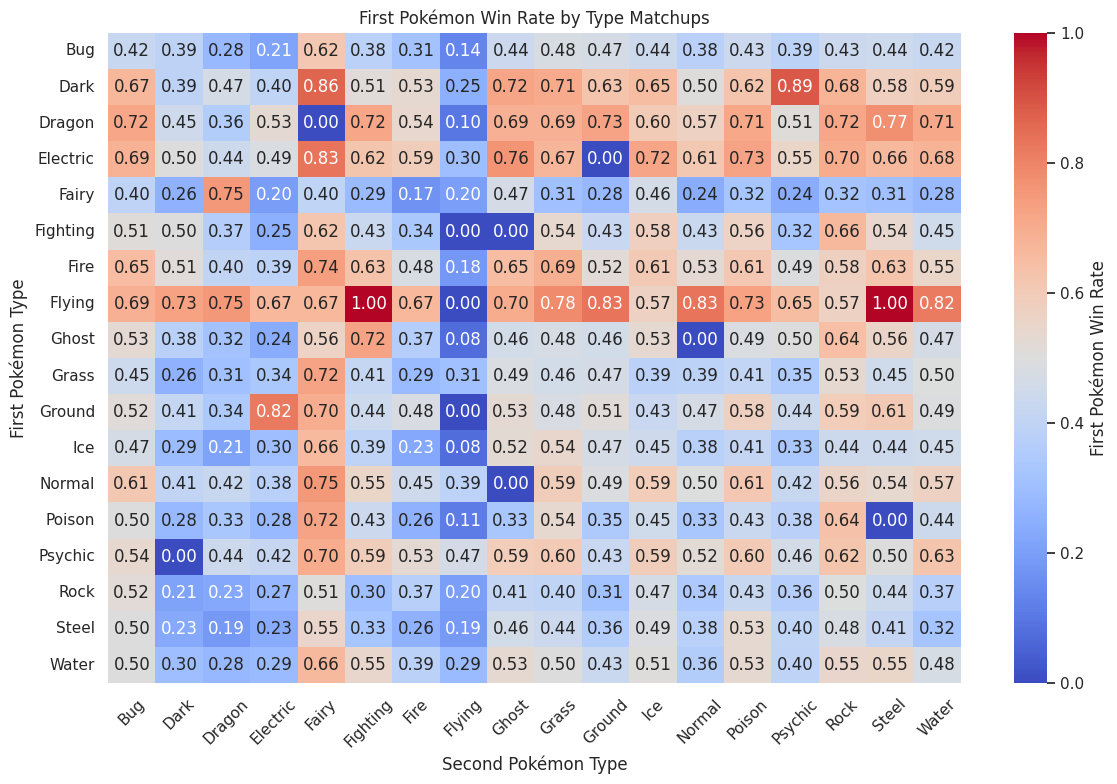

In [56]:
# Create a new DataFrame with just needed columns
type_matchups = merged_pokemon[['First_Type 1', 'Second_Type 1', 'Winner']]

# Group by type matchups and compute average win rate for First Pokémon
type_winrate = type_matchups.groupby(['First_Type 1', 'Second_Type 1'])['Winner'].mean().reset_index()

# Pivot for heatmap
type_winrate_pivot = type_winrate.pivot(index='First_Type 1', columns='Second_Type 1', values='Winner')

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(type_winrate_pivot, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'First Pokémon Win Rate'})
plt.title("First Pokémon Win Rate by Type Matchups")
plt.ylabel("First Pokémon Type")
plt.xlabel("Second Pokémon Type")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


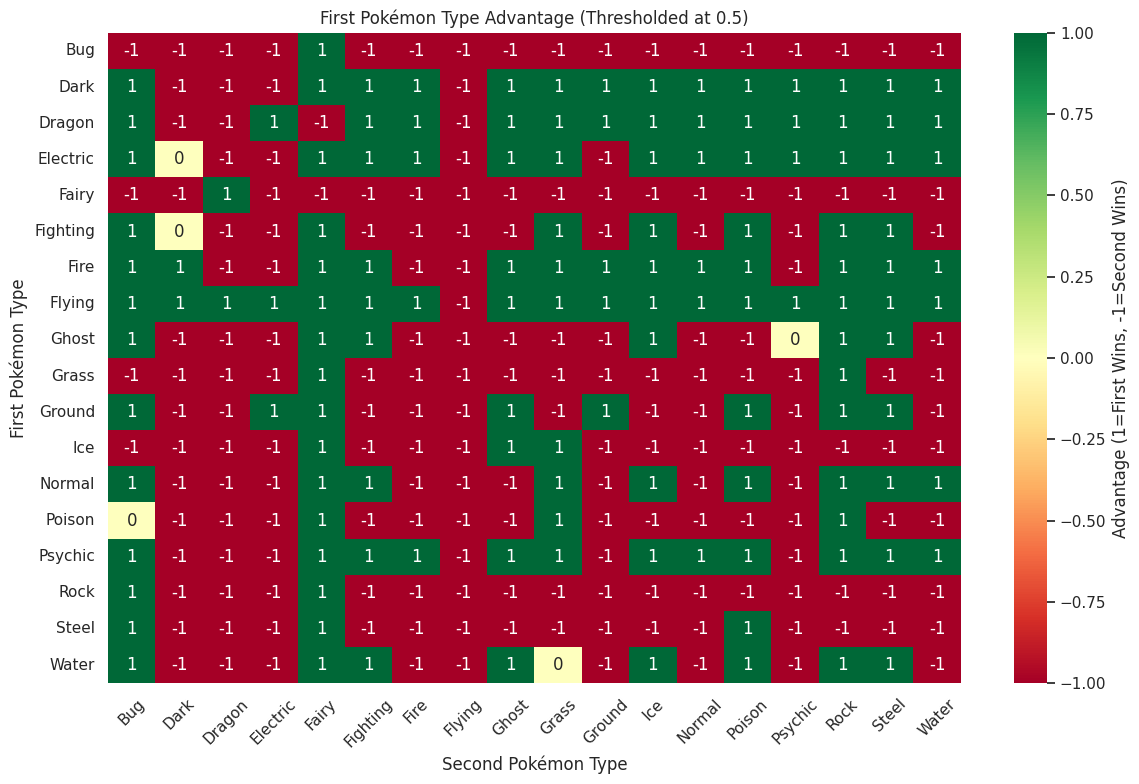

In [57]:
# Group and compute mean win rate
type_matchups = merged_pokemon[['First_Type 1', 'Second_Type 1', 'Winner']]
type_winrate = type_matchups.groupby(['First_Type 1', 'Second_Type 1'])['Winner'].mean().reset_index()

# Apply threshold logic
def win_category(rate):
    if rate > 0.5:
        return 1
    elif rate < 0.5:
        return -1
    else:
        return 0

type_winrate['Advantage'] = type_winrate['Winner'].apply(win_category)

# Pivot for heatmap
type_advantage = type_winrate.pivot(index='First_Type 1', columns='Second_Type 1', values='Advantage')

# Plot
plt.figure(figsize=(12, 8))
sns.heatmap(type_advantage, annot=True, cmap='RdYlGn', center=0, cbar_kws={'label': 'Advantage (1=First Wins, -1=Second Wins)'})
plt.title("First Pokémon Type Advantage (Thresholded at 0.5)")
plt.xlabel("Second Pokémon Type")
plt.ylabel("First Pokémon Type")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


### Understanding the Water vs Fire Matchup

When we closely inspect the **Water vs Fire** matchup, the surprising result starts to make more sense. We find that:

- **Fire-type Pokémon** in these battles were **more often Legendary**.
- The **overall stat difference** between the two sides was significant, favoring Fire types.

This suggests that **type advantage alone doesn't determine the outcome** — factors like **total stats** and **Legendary status** can heavily influence the results.

Moreover, this implies that **type effectiveness can indeed be confirmed from data**, but in practice, **players often try to mitigate type disadvantages** by choosing **higher-statted Pokémon**, even if they have a weaker type matchup. This strategic behavior may obscure clear type-based patterns in combat outcomes.


In [58]:
# Define stat columns for each Pokémon
stat_cols = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']

# Create First_Total
merged_pokemon['First_Total'] = merged_pokemon[[f'First_{col}' for col in stat_cols]].sum(axis=1)

# Create Second_Total
merged_pokemon['Second_Total'] = merged_pokemon[[f'Second_{col}' for col in stat_cols]].sum(axis=1)

# Confirm it worked
print(merged_pokemon[['First_Total', 'Second_Total']].head())


   First_Total  Second_Total
0          300           340
1          580           580
2          405           485
3          250           485
4          495           505


In [59]:
# Step 1: Filter Water vs Fire battles
water_vs_fire = merged_pokemon[
    (merged_pokemon['First_Type 1'] == 'Water') &
    (merged_pokemon['Second_Type 1'] == 'Fire')
]

# Step 2: Count of such battles
print(f"Total Water vs Fire battles: {len(water_vs_fire)}")

# Step 3: Group by outcome (Winner: 1 = Water wins, 0 = Fire wins)
win_counts = water_vs_fire['Winner'].value_counts()
print("\nWin counts (1 = Water wins, 0 = Fire wins):")
print(win_counts)

# Step 4: Compare average base stats
stat_cols = ['First_Total', 'Second_Total']

avg_stats = water_vs_fire.groupby('Winner')[stat_cols].mean()
print("\nAverage Base Stat Totals (by winner):")
print(avg_stats)

# Step 5: Compare Legendary status
legendary_cols = ['First_Legendary', 'Second_Legendary']
legendary_counts = water_vs_fire.groupby('Winner')[legendary_cols].sum()
print("\nLegendary Counts (by winner):")
print(legendary_counts)


Total Water vs Fire battles: 476

Win counts (1 = Water wins, 0 = Fire wins):
Winner
0    292
1    184
Name: count, dtype: int64

Average Base Stat Totals (by winner):
        First_Total  Second_Total
Winner                           
0        402.150685    490.880137
1        468.961957    415.500000

Legendary Counts (by winner):
        First_Legendary  Second_Legendary
Winner                                   
0                     7                29
1                    14                15


### Does Having a Secondary Type Provide an Advantage?

Another important question is whether having a **secondary type** gives a Pokémon an edge in battles. If it doesn’t, we might choose to **exclude it from our predictive models** to reduce complexity.

When we inspect **winrates**, we notice that having a secondary type seems to **provide a slight advantage**—especially when the **first Pokémon has one**. However, as we'll explore **later in the notebook**, this observation is **primarily driven by the Flying type**, which is frequently present as a secondary type and exhibits **dominant performance**.

Thus, the perceived advantage of a secondary type may not be generalizable and is likely **biased by the effectiveness of specific types**, such as Flying.


                        Num Battles  First Win Rate
Only First Has Type 2       12495.0           0.534
Only Second Has Type 2      12541.0           0.398
Both Have Type 2            13474.0           0.475
Neither Has Type 2          11490.0           0.481


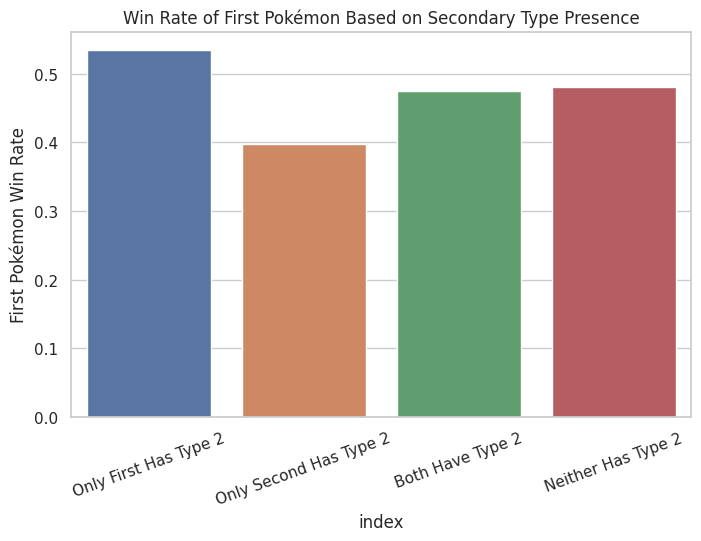

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Step 1: Create flags for having a second type
merged_pokemon['First_Has_SecondType'] = merged_pokemon['First_Type 2'].notnull()
merged_pokemon['Second_Has_SecondType'] = merged_pokemon['Second_Type 2'].notnull()

# Step 2: Define result column: 1 if First wins, 0 otherwise
merged_pokemon['First_Wins'] = merged_pokemon['Winner']

# Step 3: Analyze win rates based on second type presence
results = defaultdict(dict)

for condition, name in [
    ((merged_pokemon['First_Has_SecondType']) & (~merged_pokemon['Second_Has_SecondType']), 'Only First Has Type 2'),
    ((~merged_pokemon['First_Has_SecondType']) & (merged_pokemon['Second_Has_SecondType']), 'Only Second Has Type 2'),
    ((merged_pokemon['First_Has_SecondType']) & (merged_pokemon['Second_Has_SecondType']), 'Both Have Type 2'),
    ((~merged_pokemon['First_Has_SecondType']) & (~merged_pokemon['Second_Has_SecondType']), 'Neither Has Type 2')
]:
    subset = merged_pokemon[condition]
    win_rate = subset['First_Wins'].mean()
    results[name]['Num Battles'] = len(subset)
    results[name]['First Win Rate'] = round(win_rate, 3)

# Step 4: Convert results to DataFrame for easy visualization
type2_advantage_df = pd.DataFrame(results).T
print(type2_advantage_df)

# Step 5: Plot the win rates
plt.figure(figsize=(8, 5))
sns.barplot(data=type2_advantage_df.reset_index(), x='index', y='First Win Rate')
plt.title('Win Rate of First Pokémon Based on Secondary Type Presence')
plt.ylabel('First Pokémon Win Rate')
plt.xticks(rotation=20)
plt.show()


### Do Newer Generations Have Stronger Pokémon?

A common assumption is that Pokémon from newer generations might be stronger due to power creep. To explore this, we examined the correlation heatmap between generation and stats.

From the heatmap, we **cannot conclude a strong relationship** between generation and overall power. While there may be slight differences in certain stats across generations, there is **no clear trend** that newer generations are inherently more powerful.

This suggests that **generation alone does not determine strength**, and other factors such as type, rarity, and specific stat distributions play a more significant role.


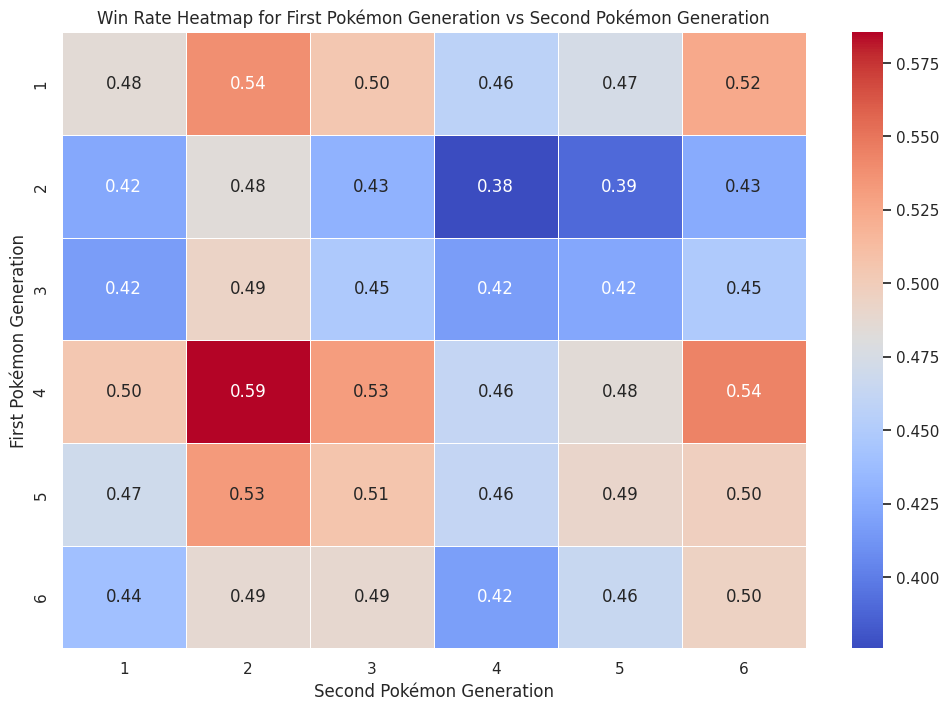

In [61]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Calculate the generation difference between the first and second Pokémon
merged_pokemon['First_Wins'] = merged_pokemon['Winner']

# Step 2: Create a pivot table showing win rates for each combination of generations
winrate_matrix = merged_pokemon.pivot_table(
    index='First_Generation', 
    columns='Second_Generation', 
    values='First_Wins', 
    aggfunc='mean'
)

# Step 3: Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(winrate_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, linewidths=0.5)
plt.title('Win Rate Heatmap for First Pokémon Generation vs Second Pokémon Generation')
plt.xlabel('Second Pokémon Generation')
plt.ylabel('First Pokémon Generation')
plt.show()


### Stat Trends Across Pokémon Types

To gain deeper insights, we explored how different **stat distributions vary by Pokémon type**. While analyzing each type-stat combination in detail would clutter the notebook, general trends can still be observed:

- Certain types tend to emphasize specific stats.  
- For example, **Fighting** types often excel in **Attack**, while **Psychic** types may have higher **Special Attack** and **Speed**.
- These patterns help us understand **type-based stat tendencies**, which can be useful for downstream modeling or strategy design.

Instead of listing every type-stat pair, we focus on highlighting **broad patterns** that are both intuitive and informative.


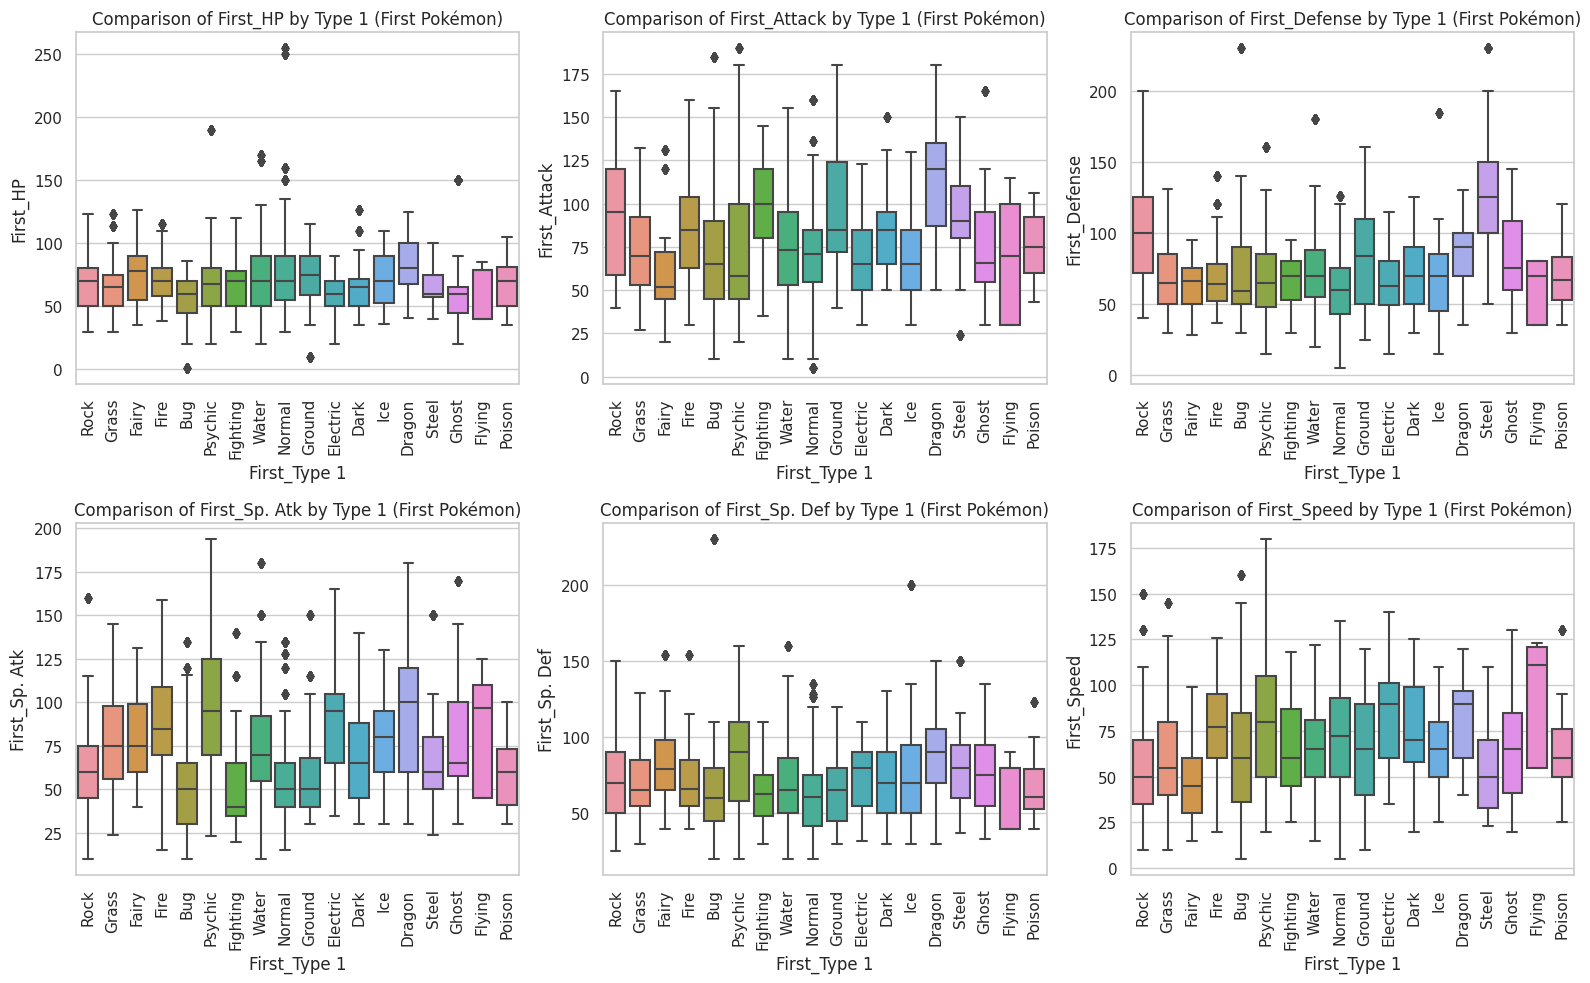

Mean Stats for First Pokémon by Type 1:
               First_HP  First_Attack  First_Defense  First_Sp. Atk  \
First_Type 1                                                          
Bug           56.832649     70.700182      70.835157      53.711810   
Dark          66.447911     87.316764      71.476996      74.680063   
Dragon        83.441624    113.496954      85.954822      95.670558   
Electric      59.498301     68.512269      65.587391      89.252926   
Fairy         74.144498     61.356938      65.737799      78.839234   
Fighting      66.944612     95.401565      65.846478      52.387718   
Fire          70.270974     85.223209      67.936620      89.134415   
Flying        69.206612     75.723140      64.710744      91.384298   
Ghost         65.686650     74.760202      81.099748      80.996977   
Grass         67.084802     72.710594      70.928588      77.396054   
Ground        73.873247     95.485195      84.490909      57.514805   
Ice           71.873249     70.760507

In [62]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Group by Type 1 and calculate the mean for each stat (for the first Pokémon)
type_stats_first = merged_pokemon.groupby('First_Type 1')[['First_HP', 'First_Attack', 'First_Defense', 
                                                          'First_Sp. Atk', 'First_Sp. Def', 'First_Speed']].mean()

# Step 2: Plot the comparison of stats for the first Pokémon across different types using boxplots
stat_columns_first = ['First_HP', 'First_Attack', 'First_Defense', 'First_Sp. Atk', 'First_Sp. Def', 'First_Speed']

plt.figure(figsize=(16, 10))
for i, stat in enumerate(stat_columns_first, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='First_Type 1', y=stat, data=merged_pokemon)
    plt.title(f'Comparison of {stat} by Type 1 (First Pokémon)')
    plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

# Step 3: Print the mean values for each stat by Type 1 (for the first Pokémon)
print("Mean Stats for First Pokémon by Type 1:")
print(type_stats_first)

# Step 4: For each stat, identify which type has the highest mean
print("\nTypes with the highest mean for each stat:")

for stat in stat_columns_first:
    max_type = type_stats_first[stat].idxmax()  # Find the type with the maximum mean for this stat
    max_value = type_stats_first[stat].max()    # Find the value of the stat for that type
    print(f"For {stat}, the type with the highest mean is {max_type} with a mean value of {max_value:.2f}")


### Base Model Training

Now, it's time to start training our base models. We will use a variety of machine learning algorithms to understand how well they perform on predicting the winner of a Pokémon battle, based on the available features.





### Insights

- **Faster Pokémon Are More Advantageous**  
  From the analysis and model results, it is clear that Pokémon with higher speed tend to have a strategic advantage in battles. Faster Pokémon can strike before the opponent, potentially dealing significant damage and securing victory without giving the opponent a chance to retaliate.

- **Importance of Categorical Features Over Numerical Differences**  
  Our tree-based models, particularly **XGBoost**, performed the best in predicting outcomes. This could be due to the inherent nature of tree-based algorithms to handle categorical features effectively. In Pokémon combat, categorical attributes such as **type** or **legendary status** appear to matter far more than numerical stats (like HP or attack power).  

  For example, the difference of 50 HP in two Pokémon may not significantly impact the battle outcome if one Pokémon possesses an advantageous type (like **Flying**) or a legendary status. This suggests that **type advantages** and **legendary status** play a more decisive role in predicting the winner than small numerical differences between Pokémon's attributes.

- **Tree-Based Models Are Superior in This Context**  
  The superior performance of **tree-based models** (like **XGBoost** and **LightGBM**) supports the idea that **categorical features** and **interaction between them** (such as type interactions) have more influence on outcomes than small numerical differences. These models effectively exploit these categorical features, while simpler models, like logistic regression, may not capture this complexity as effectively.


### Data Splitting

We split the dataset into three sets to ensure proper model evaluation:

- **Training Set**:
  - Used to train the model.
  - Contains the majority of the data and is used to adjust model parameters.
  
- **Validation Set**:
  - Used to tune the hyperparameters and make decisions about model adjustments.
  - Helps to prevent overfitting by providing an independent evaluation during training.
  
- **Test Set**:
  - Kept separate from the model during training and validation.
  - Used to assess the final model's performance and its ability to generalize to new, unseen data.


In [63]:
import pandas as pd
from sklearn.model_selection import train_test_split

# --- Select features ---
features = [
    'First_HP', 'First_Attack', 'First_Defense', 'First_Sp. Atk', 'First_Sp. Def', 'First_Speed',
    'Second_HP', 'Second_Attack', 'Second_Defense', 'Second_Sp. Atk', 'Second_Sp. Def', 'Second_Speed',
    'First_Generation', 'Second_Generation', 'First_Legendary', 'Second_Legendary',
    'First_Type 1', 'Second_Type 1'
]

# --- Copy data & one-hot encode ---
df_model = merged_pokemon[features + ['Winner']].copy()
df_model = pd.get_dummies(df_model, columns=['First_Type 1', 'Second_Type 1'], drop_first=True)

# --- Split into train, val, test ---
X = df_model.drop('Winner', axis=1)
y = df_model['Winner']

# Step 1: Train + Temp split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

# Step 2: Temp -> Val + Test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# --- Result sizes ---
print("Train:", X_train.shape)
print("Validation:", X_val.shape)
print("Test:", X_test.shape)


Train: (30000, 50)
Validation: (10000, 50)
Test: (10000, 50)


### Logistic Regression

We started with **Logistic Regression** as our base model, which is a simple and efficient algorithm for binary classification. After training the model on the dataset, we evaluated its performance:

- **F1 Score**: 0.89
  - Indicates a good balance between precision and recall, making the model reliable in handling both false positives and false negatives.
  
- **Validation Accuracy**: 88.77%
  - Shows that the model performs well on unseen validation data, providing a strong indication of its ability to generalize.


Validation Accuracy: 0.8879

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.90      0.89      5280
           1       0.88      0.88      0.88      4720

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



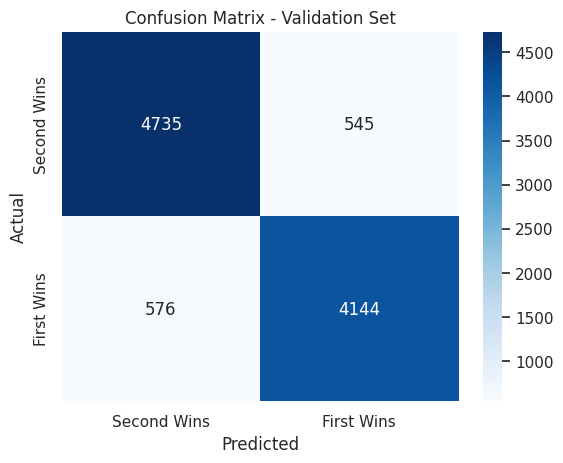

In [64]:

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt



# --- Initialize and train logistic regression ---
log_reg = LogisticRegression(max_iter=1000, solver='lbfgs')
log_reg.fit(X_train, y_train)

# --- Predict on validation set ---
y_val_pred = log_reg.predict(X_val)



# --- Evaluate ---
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

# --- Confusion Matrix ---
cm = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Second Wins', 'First Wins'], yticklabels=['Second Wins', 'First Wins'])
plt.title("Confusion Matrix - Validation Set")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


### XGBoost

Next, we implemented **XGBoost**, a more advanced and powerful gradient boosting algorithm. The model was trained and evaluated on the same dataset:

- **F1 Score**: 0.96
  - Significantly improved compared to Logistic Regression, reflecting a better balance between precision and recall.
  
- **Validation Accuracy**: 96%
  - Achieved a high validation accuracy, indicating that XGBoost can generalize well to unseen data, outperforming Logistic Regression.


Validation Accuracy: 0.9618

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.96      5280
           1       0.96      0.96      0.96      4720

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



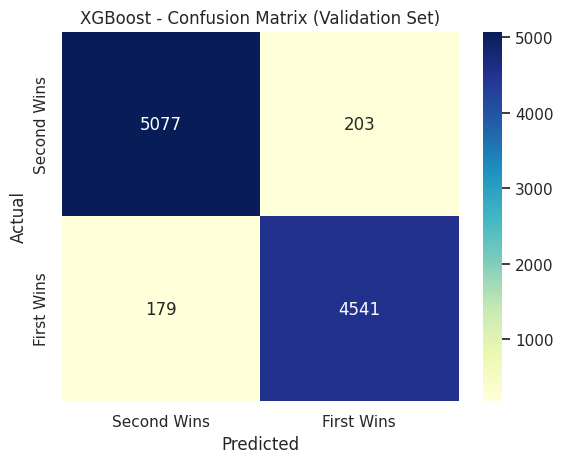

In [65]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Train the model
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_clf.fit(X_train, y_train)

# Predict on validation
y_val_pred = xgb_clf.predict(X_val)

# Evaluate
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=['Second Wins', 'First Wins'], yticklabels=['Second Wins', 'First Wins'])
plt.title("XGBoost - Confusion Matrix (Validation Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


### Feature Importance with XGBoost

To understand which features contributed the most to the model's decision-making process, we analyzed the feature importance based on the trained **XGBoost** model.

- **Feature Importance**:
  - We used the built-in functionality of XGBoost to extract and visualize the feature importance scores.
  - The features that contributed most to the prediction were identified, helping us understand which Pokémon stats and types were most influential in determining the winner.
  
This analysis helps interpret the model's behavior and provides insights into which attributes play a critical role in the combat outcomes.


###  Insights on Feature Importance

Upon inspecting the feature importance, we observe a trend that was highlighted earlier regarding **Flying-type Pokémon**.

- **Flying-type Advantage**:
  - Pokémon with **high speed and high attack** stats tend to dominate in higher-level competitive play (high Elo). This is because, in Pokémon battles, speed plays a crucial role. Faster Pokémon can attack first, potentially knocking out the opponent without taking damage in return.
  - The **Flying-type** often benefits from this strategy, as it tends to be associated with faster and stronger Pokémon. This aligns with the observation that players prefer using fast Pokémon to maximize their chances of delivering damage while minimizing exposure to the opponent's attacks.
  
This behavior is reflected in the feature importance and win rates, where Flying-type Pokémon appear more often in the winning combination, as they are more likely to have a favorable stat balance of speed and attack.


<Figure size 1200x800 with 0 Axes>

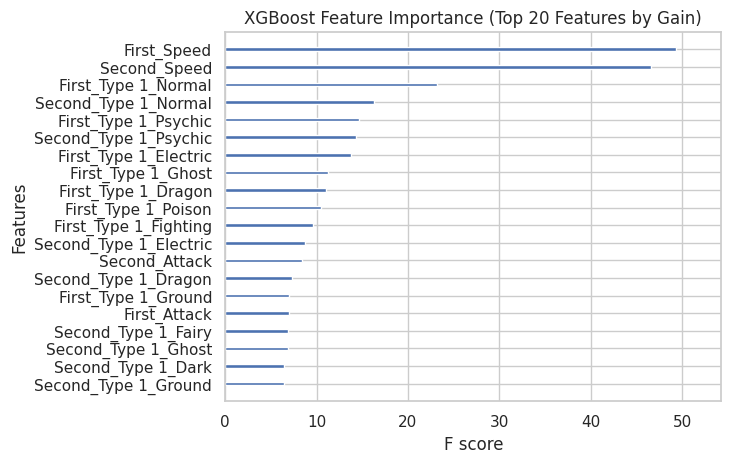

In [66]:
from xgboost import plot_importance

# Plot feature importance
plt.figure(figsize=(12, 8))
plot_importance(xgb_clf, max_num_features=20, importance_type='gain', show_values=False)
plt.title("XGBoost Feature Importance (Top 20 Features by Gain)")
plt.show()

### LightGBM

### LightGBM Model Results

- **Validation Accuracy**: 0.95  
- **F1 Score**: 0.96  

Upon training the LightGBM model, we achieved a solid **validation accuracy of 95%** and an **F1 score of 0.96**, indicating strong model performance. 

- **Feature Importance**:
  - The **feature importance** from the LightGBM model corroborated our previous findings from the XGBoost model, confirming the trends we observed earlier. The features related to **speed** and **attack** continue to dominate, especially when paired with **Flying-type** Pokémon.
  - As in XGBoost, **Flying-type** Pokémon appear to be a key feature, as they are often associated with faster and more offensive Pokémon, which aligns with the strategy of maximizing speed and attack to dominate early in battles.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 14161, number of negative: 15839
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1318
[LightGBM] [Info] Number of data points in the train set: 30000, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.472033 -> initscore=-0.111984
[LightGBM] [Info] Start training from score -0.111984
Validation Accuracy: 0.9595

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.96      5280
           1       0.95      0.96      0.96      4720

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96    

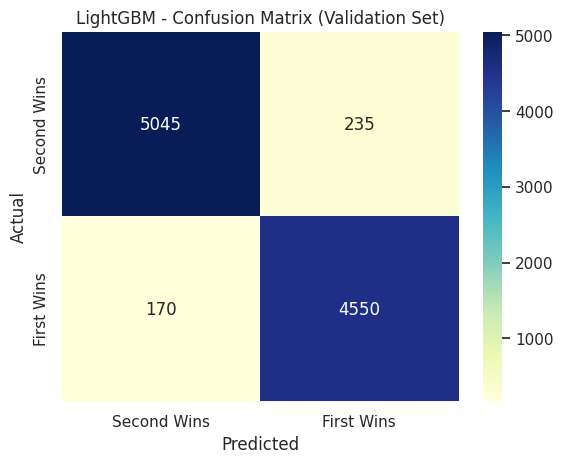

In [67]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the classifier
lgb_clf = lgb.LGBMClassifier()

# Train
lgb_clf.fit(X_train, y_train)

# Predict on validation
y_val_pred = lgb_clf.predict(X_val)

# Evaluate
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=['Second Wins', 'First Wins'], yticklabels=['Second Wins', 'First Wins'])
plt.title("LightGBM - Confusion Matrix (Validation Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


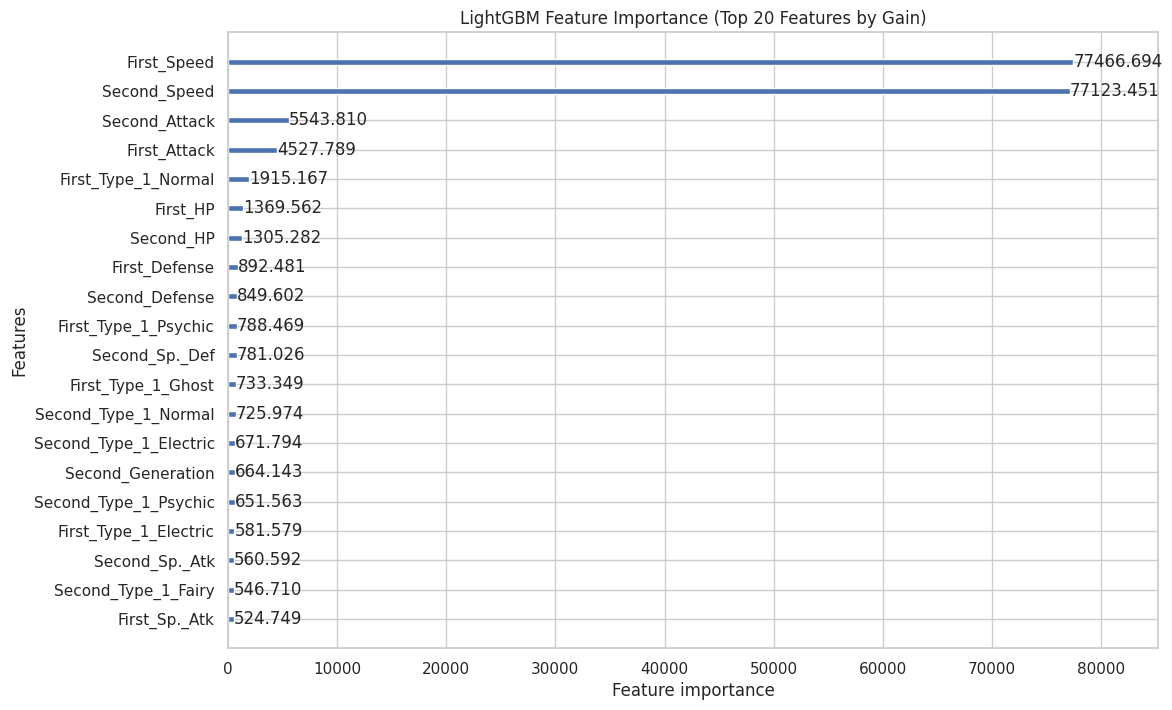

In [68]:
# Plot feature importance
lgb.plot_importance(lgb_clf, max_num_features=20, importance_type='gain', figsize=(12, 8))
plt.title("LightGBM Feature Importance (Top 20 Features by Gain)")
plt.show()

### CatBoost Model Results

- **Validation Accuracy**: 0.9614  
- **F1 Score**: 0.96  

We trained the **CatBoost** model, which automatically handles categorical features without the need for extra preprocessing. However, despite this convenience, we still needed to perform some additional steps to ensure the data was in the right format for optimal results.

- **Results**: 
  - The model achieved an impressive **validation accuracy of 96.14%** and an **F1 score of 0.96**, showing that it performed well in distinguishing between Pokémon outcomes.


In [69]:
import pandas as pd
from sklearn.model_selection import train_test_split

# --- Select features (categorical columns are kept as-is) ---
features = [
    'First_HP', 'First_Attack', 'First_Defense', 'First_Sp. Atk', 'First_Sp. Def', 'First_Speed',
    'Second_HP', 'Second_Attack', 'Second_Defense', 'Second_Sp. Atk', 'Second_Sp. Def', 'Second_Speed',
    'First_Generation', 'Second_Generation', 'First_Legendary', 'Second_Legendary',
    'First_Type 1', 'Second_Type 1'
]

# --- Create DataFrame for CatBoost ---
df_model_cat = merged_pokemon[features + ['Winner']].copy()

# --- Separate features and target ---
X_cat = df_model_cat.drop('Winner', axis=1)
y_cat = df_model_cat['Winner']

# --- Identify categorical columns (either by name or index) ---
categorical_features = ['First_Type 1', 'Second_Type 1']

# --- Split into train, val, test (preserve class balance) ---
X_train_cat, X_temp_cat, y_train_cat, y_temp_cat = train_test_split(
    X_cat, y_cat, test_size=0.4, random_state=42, stratify=y_cat
)

X_val_cat, X_test_cat, y_val_cat, y_test_cat = train_test_split(
    X_temp_cat, y_temp_cat, test_size=0.5, random_state=42, stratify=y_temp_cat
)

# --- Result sizes ---
print("Train:", X_train_cat.shape)
print("Validation:", X_val_cat.shape)
print("Test:", X_test_cat.shape)


Train: (30000, 18)
Validation: (10000, 18)
Test: (10000, 18)


In [70]:
from catboost import CatBoostClassifier

# Define categorical feature names — only include those present in df_model_cat
categorical_features = ['First_Type 1', 'Second_Type 1']

# Initialize the CatBoost classifier
cat_clf = CatBoostClassifier(
    verbose=100,
    random_seed=42,
    eval_metric='Accuracy'  # or 'Logloss', depending on what you want to optimize
)

# Fit the model — using the updated variables
cat_clf.fit(
    X_train_cat, y_train_cat,
    cat_features=categorical_features,
    eval_set=(X_val_cat, y_val_cat),
    use_best_model=True
)


Learning rate set to 0.07341
0:	learn: 0.8692000	test: 0.8655000	best: 0.8655000 (0)	total: 23ms	remaining: 23s
100:	learn: 0.9466333	test: 0.9434000	best: 0.9434000 (100)	total: 1.98s	remaining: 17.6s
200:	learn: 0.9560667	test: 0.9525000	best: 0.9525000 (200)	total: 3.82s	remaining: 15.2s
300:	learn: 0.9612000	test: 0.9545000	best: 0.9548000 (262)	total: 5.62s	remaining: 13.1s
400:	learn: 0.9646333	test: 0.9553000	best: 0.9558000 (355)	total: 7.42s	remaining: 11.1s
500:	learn: 0.9681333	test: 0.9570000	best: 0.9570000 (500)	total: 9.3s	remaining: 9.27s
600:	learn: 0.9714333	test: 0.9589000	best: 0.9589000 (599)	total: 11.2s	remaining: 7.42s
700:	learn: 0.9736000	test: 0.9599000	best: 0.9601000 (683)	total: 13s	remaining: 5.56s
800:	learn: 0.9759000	test: 0.9597000	best: 0.9601000 (683)	total: 14.9s	remaining: 3.7s
900:	learn: 0.9777667	test: 0.9605000	best: 0.9607000 (831)	total: 16.8s	remaining: 1.84s
999:	learn: 0.9800667	test: 0.9610000	best: 0.9614000 (979)	total: 18.7s	remaining

In [71]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predict on validation set
val_preds = cat_clf.predict(X_val_cat)

# Accuracy
val_accuracy = accuracy_score(y_val_cat, val_preds)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_val_cat, val_preds))

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_val_cat, val_preds))


Validation Accuracy: 0.9614

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      5280
           1       0.96      0.96      0.96      4720

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000


Confusion Matrix:
[[5073  207]
 [ 179 4541]]


## Unsupervised Learning: K-Means Clustering

In this section, we will implement K-Means clustering to explore the data from an unsupervised learning perspective. K-Means will help us identify inherent patterns in the dataset without any predefined labels.


### K-Means

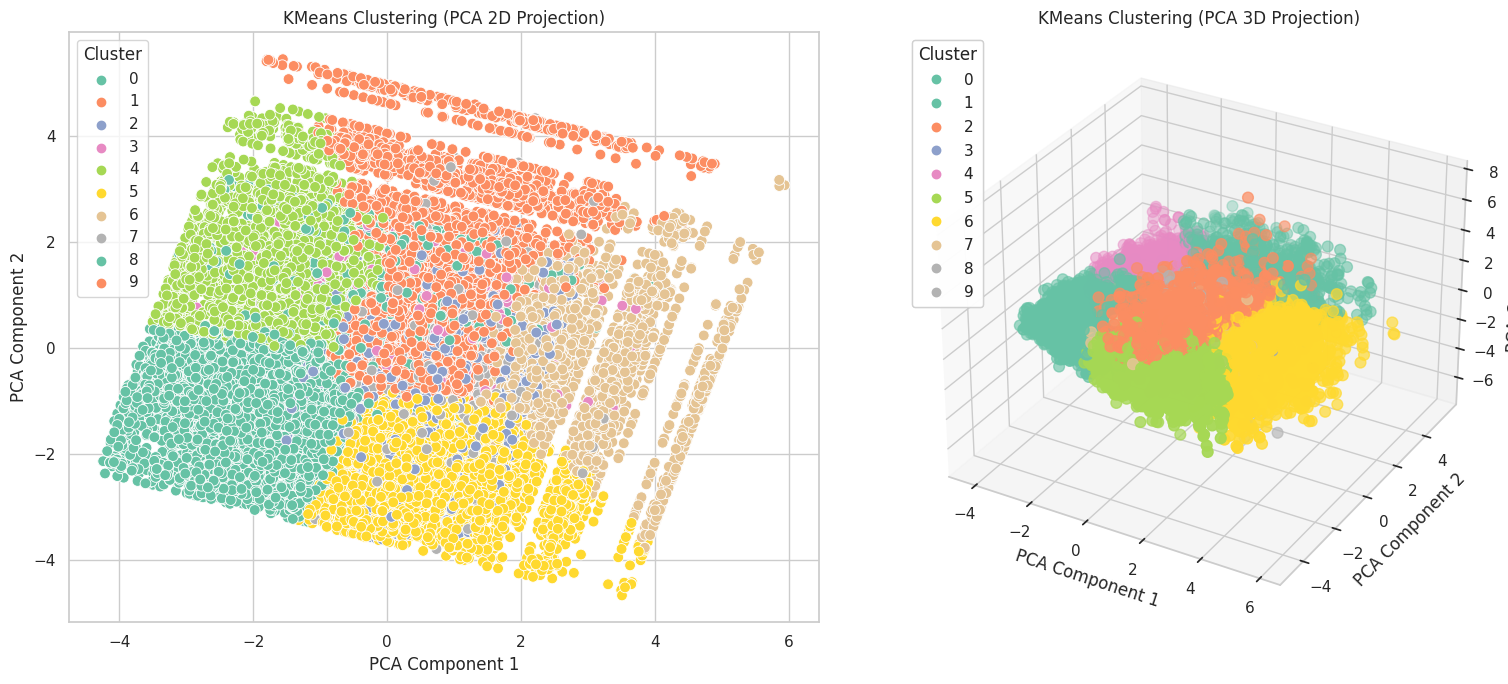

In [72]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D plotting

# --- Step 1: Select features for clustering ---
features_kmeans = [
    'First_HP', 'First_Attack', 'First_Defense', 'First_Sp. Atk', 'First_Sp. Def', 'First_Speed',
    'Second_HP', 'Second_Attack', 'Second_Defense', 'Second_Sp. Atk', 'Second_Sp. Def', 'Second_Speed'
]
X_kmeans = merged_pokemon[features_kmeans]

# --- Step 2: Scale the features ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_kmeans)

# --- Step 3: Apply KMeans clustering ---
kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# --- Step 4: Apply PCA (3 components for 3D, reuse first 2 for 2D) ---
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# --- Step 5: Plot side-by-side 2D and 3D PCA visualizations ---
fig = plt.figure(figsize=(16, 7))

# 2D plot
ax1 = fig.add_subplot(1, 2, 1)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters, palette='Set2', s=60, ax=ax1)
ax1.set_title("KMeans Clustering (PCA 2D Projection)")
ax1.set_xlabel("PCA Component 1")
ax1.set_ylabel("PCA Component 2")
ax1.legend(title='Cluster')
ax1.grid(True)

# 3D plot
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
scatter = ax2.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=clusters, cmap='Set2', s=60)
ax2.set_title("KMeans Clustering (PCA 3D Projection)")
ax2.set_xlabel("PCA Component 1")
ax2.set_ylabel("PCA Component 2")
ax2.set_zlabel("PCA Component 3")
legend = ax2.legend(*scatter.legend_elements(), title="Cluster", loc="upper left")
ax2.add_artist(legend)

plt.tight_layout()
plt.show()


## 🔍 Cluster Analysis: Determining the Optimal Number of Clusters

Based on both the **Silhouette Score** and the **Elbow Method**, we concluded that **3** is the optimal number of clusters for our data. 

### 📊 Observations:
- The **Silhouette Score** and **Elbow Graph** both suggested that 3 clusters provide the best balance between cohesion and separation.
- Upon inspecting the cluster distributions, we noticed that certain **first types** were consistently grouped together, indicating potential patterns that could be useful for further feature engineering or model refinement.

This clustering insight could help us better understand the underlying structure of the data, potentially guiding future steps in feature selection or model adjustments.


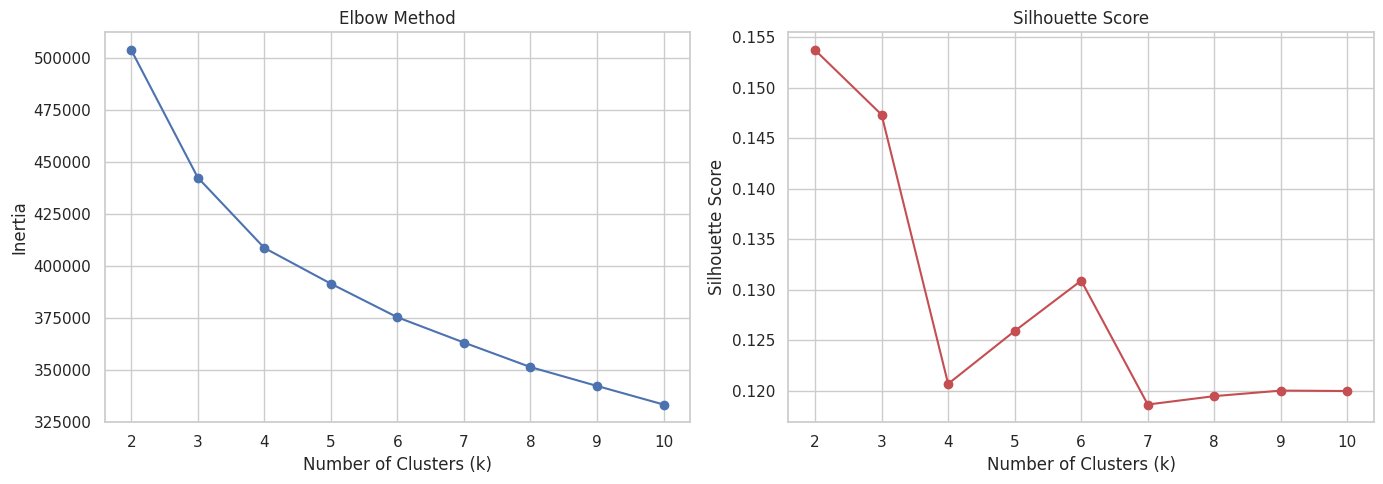

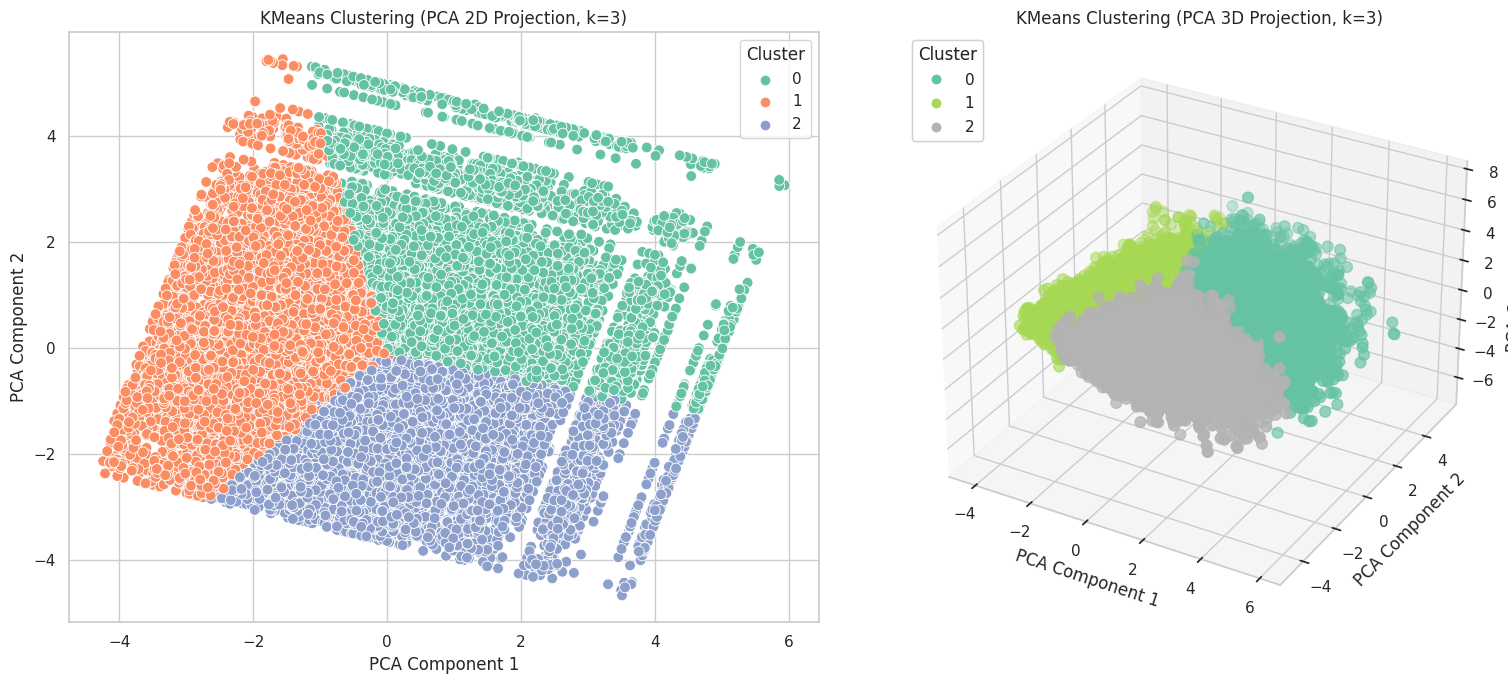

In [73]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D plotting

# --- Step 1: Select features for clustering ---
features_kmeans = [
    'First_HP', 'First_Attack', 'First_Defense', 'First_Sp. Atk', 'First_Sp. Def', 'First_Speed',
    'Second_HP', 'Second_Attack', 'Second_Defense', 'Second_Sp. Atk', 'Second_Sp. Def', 'Second_Speed'
]
X_kmeans = merged_pokemon[features_kmeans]

# --- Step 2: Scale the features ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_kmeans)

# --- Step 3: Determine optimal number of clusters ---
inertia = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))

# --- Step 4: Plot Elbow and Silhouette Score ---
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].plot(k_range, inertia, 'bo-')
ax[0].set_title('Elbow Method')
ax[0].set_xlabel('Number of Clusters (k)')
ax[0].set_ylabel('Inertia')
ax[0].grid(True)

ax[1].plot(k_range, silhouette_scores, 'ro-')
ax[1].set_title('Silhouette Score')
ax[1].set_xlabel('Number of Clusters (k)')
ax[1].set_ylabel('Silhouette Score')
ax[1].grid(True)

plt.tight_layout()
plt.show()

# --- Step 5: Apply KMeans clustering with chosen k ---
# Change this based on Elbow/Silhouette plot result
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# --- Step 6: Apply PCA (3 components for 3D, reuse first 2 for 2D) ---
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# --- Step 7: Plot side-by-side 2D and 3D PCA visualizations ---
fig = plt.figure(figsize=(16, 7))

# 2D plot
ax1 = fig.add_subplot(1, 2, 1)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters, palette='Set2', s=60, ax=ax1)
ax1.set_title(f"KMeans Clustering (PCA 2D Projection, k={optimal_k})")
ax1.set_xlabel("PCA Component 1")
ax1.set_ylabel("PCA Component 2")
ax1.legend(title='Cluster')
ax1.grid(True)

# 3D plot
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
scatter = ax2.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=clusters, cmap='Set2', s=60)
ax2.set_title(f"KMeans Clustering (PCA 3D Projection, k={optimal_k})")
ax2.set_xlabel("PCA Component 1")
ax2.set_ylabel("PCA Component 2")
ax2.set_zlabel("PCA Component 3")
legend = ax2.legend(*scatter.legend_elements(), title="Cluster", loc="upper left")
ax2.add_artist(legend)

plt.tight_layout()
plt.show()


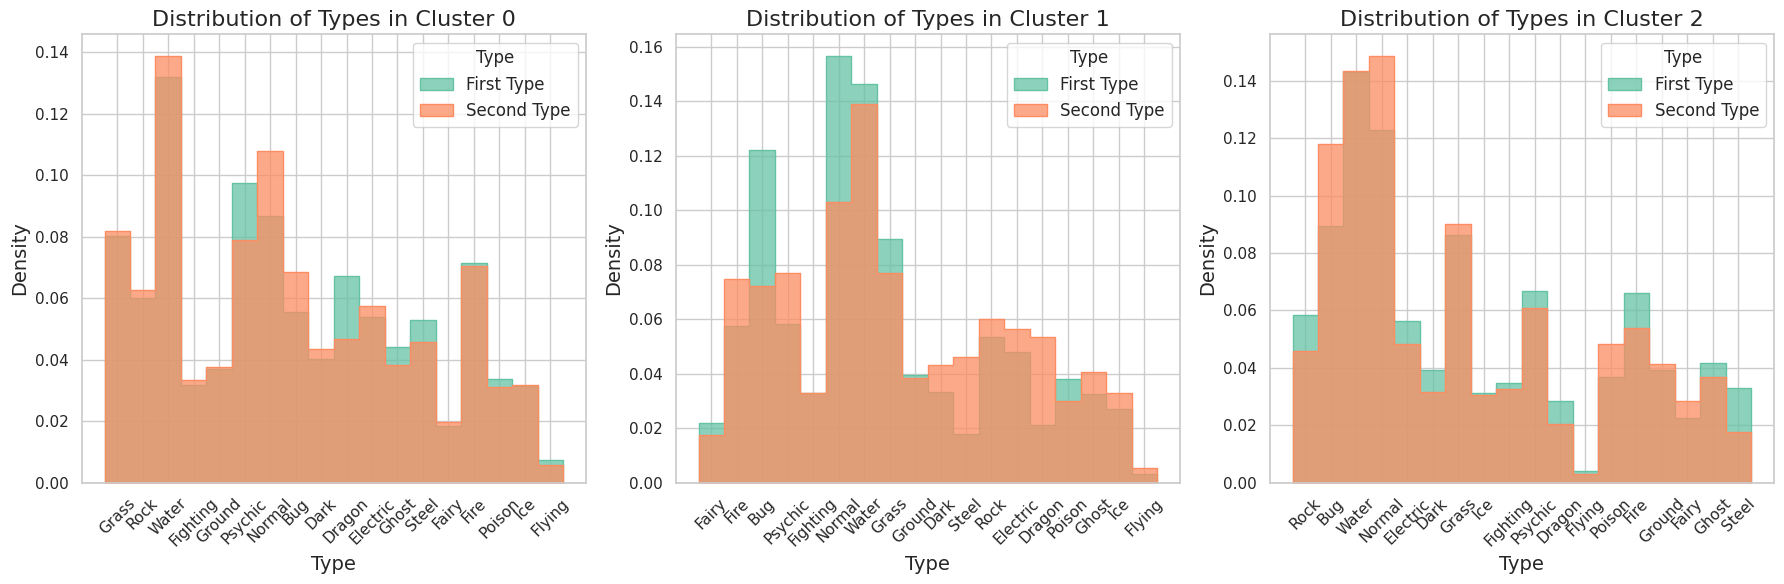

In [74]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# --- Step 1: Select features for clustering ---
features_kmeans = [
    'First_HP', 'First_Attack', 'First_Defense', 'First_Sp. Atk', 'First_Sp. Def', 'First_Speed',
    'Second_HP', 'Second_Attack', 'Second_Defense', 'Second_Sp. Atk', 'Second_Sp. Def', 'Second_Speed'
]

X_kmeans = merged_pokemon[features_kmeans]

# --- Step 2: Fit KMeans ---
kmeans = KMeans(n_clusters=3, random_state=42)  # Changed n_clusters to 3
clusters = kmeans.fit_predict(X_kmeans)

# Add cluster labels to the dataframe
merged_pokemon['Cluster'] = clusters

# --- Step 3: Create distribution plots for each cluster ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Adjusted to 1 row and 3 columns

# Plot for Cluster 0
cluster_0 = merged_pokemon[merged_pokemon['Cluster'] == 0]
sns.histplot(cluster_0['First_Type 1'], kde=False, ax=axes[0], color=sns.color_palette("Set2")[0], discrete=True, label='First Type', element="step", stat="density")
sns.histplot(cluster_0['Second_Type 1'], kde=False, ax=axes[0], color=sns.color_palette("Set2")[1], discrete=True, label='Second Type', element="step", stat="density")
axes[0].set_title("Distribution of Types in Cluster 0", fontsize=16)
axes[0].set_xlabel("Type", fontsize=14)
axes[0].set_ylabel("Density", fontsize=14)
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend(title="Type", loc='upper right', fontsize=12)

# Plot for Cluster 1
cluster_1 = merged_pokemon[merged_pokemon['Cluster'] == 1]
sns.histplot(cluster_1['First_Type 1'], kde=False, ax=axes[1], color=sns.color_palette("Set2")[0], discrete=True, label='First Type', element="step", stat="density")
sns.histplot(cluster_1['Second_Type 1'], kde=False, ax=axes[1], color=sns.color_palette("Set2")[1], discrete=True, label='Second Type', element="step", stat="density")
axes[1].set_title("Distribution of Types in Cluster 1", fontsize=16)
axes[1].set_xlabel("Type", fontsize=14)
axes[1].set_ylabel("Density", fontsize=14)
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(title="Type", loc='upper right', fontsize=12)

# Plot for Cluster 2
cluster_2 = merged_pokemon[merged_pokemon['Cluster'] == 2]
sns.histplot(cluster_2['First_Type 1'], kde=False, ax=axes[2], color=sns.color_palette("Set2")[0], discrete=True, label='First Type', element="step", stat="density")
sns.histplot(cluster_2['Second_Type 1'], kde=False, ax=axes[2], color=sns.color_palette("Set2")[1], discrete=True, label='Second Type', element="step", stat="density")
axes[2].set_title("Distribution of Types in Cluster 2", fontsize=16)
axes[2].set_xlabel("Type", fontsize=14)
axes[2].set_ylabel("Density", fontsize=14)
axes[2].tick_params(axis='x', rotation=45)
axes[2].legend(title="Type", loc='upper right', fontsize=12)

# Adjust layout for better spacing and appearance
plt.tight_layout()
plt.show()


## 📈 Improving the Model: Feature Engineering Strategies

To enhance the performance of our model, we'll explore and test several **feature engineering techniques**. 

Feature engineering plays a critical role in helping machine learning models extract meaningful patterns from the data. By crafting new features or transforming existing ones, we can often boost model accuracy and robustness.

To streamline our experimentation process, we begin by defining a **reusable training function** for the XGBoost model. This allows us to efficiently test different sets of features under consistent training conditions.

In the following steps, we’ll:

- Apply and compare multiple feature engineering strategies
- Evaluate their impact using a consistent validation approach
- Select the most promising features for our final model



In [75]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

def train_xgboost_model(merged_df, feature_list,top_n=20):
    """
    Trains an XGBoost model on the given set of features and evaluates it on a validation set.
    
    Parameters:
        merged_df (pd.DataFrame): The merged dataset containing all features and 'Winner'.
        feature_list (list): List of feature column names to include.
        top_n(int) : number of how many features we want to observe which impacts the least.
    
    Returns:
        model (XGBClassifier): Trained XGBoost model.
    """
    # --- Prepare data ---
    df_model = merged_df[feature_list + ['Winner']].copy()
    
    # One-hot encoding of categorical features
    df_model = pd.get_dummies(df_model, columns=['First_Type 1', 'Second_Type 1'], drop_first=True)

    X = df_model.drop('Winner', axis=1)
    y = df_model['Winner']

    # --- Split dataset: 60% train, 20% val, 20% test ---
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
    
    # --- Train model ---
    model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train, y_train)

    # --- Predict & evaluate on validation set ---
    y_val_pred = model.predict(X_val)
    
    print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
    print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

    # --- Confusion matrix ---
    cm = confusion_matrix(y_val, y_val_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', 
                xticklabels=['Second Wins', 'First Wins'], 
                yticklabels=['Second Wins', 'First Wins'])
    plt.title("XGBoost - Confusion Matrix (Validation Set)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    importance_dict = model.get_booster().get_score(importance_type='gain')
    
    # Ensure all features are accounted for
    all_features = pd.Series(index=X_train.columns, data=0.0)
    for k, v in importance_dict.items():
        all_features[k] = v

    # Sort ascending (least important first)
    least_important = all_features.sort_values(ascending=True).head(top_n)

    # Plot
    plt.figure(figsize=(10, 6))
    least_important.plot(kind='barh', color='salmon')
    plt.title(f"Least {top_n} Important Features (by Gain)")
    plt.xlabel("Feature Importance (Gain)")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 8))
    plot_importance(xgb_clf, max_num_features=20, importance_type='gain', show_values=False)
    plt.title("XGBoost Feature Importance (Top 20 Features by Gain)")
    plt.show()


    return model





## 🔬 Experiment 0: Baseline Reference Model

In this initial experiment, we simply revisit our **base model** — trained without any additional feature engineering.

No new features were created or transformed. The goal here is to establish a **reference point** for performance, which will help us quantify the impact of future feature engineering strategies.

This baseline will serve as a **benchmark** against which all subsequent experiments will be evaluated.


Interestingly, when we examine the **least impactful features**, we observe that the `Flying` type has **minimal influence** on the model's predictions. While this may seem **contradictory** to our earlier assumptions, it is likely due to the fact that the model is already able to infer relevant information from other features — particularly the **first and second speed values**, which appear to carry **greater predictive power**.

This insight emphasizes the importance of analyzing **feature interactions** rather than focusing solely on individual feature importance scores.

Validation Accuracy: 0.9618

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.96      5280
           1       0.96      0.96      0.96      4720

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



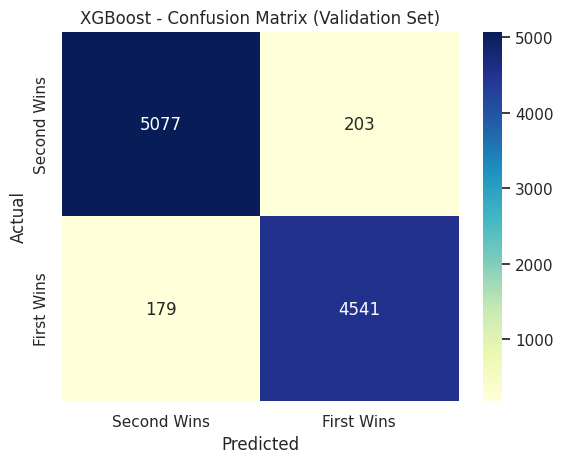

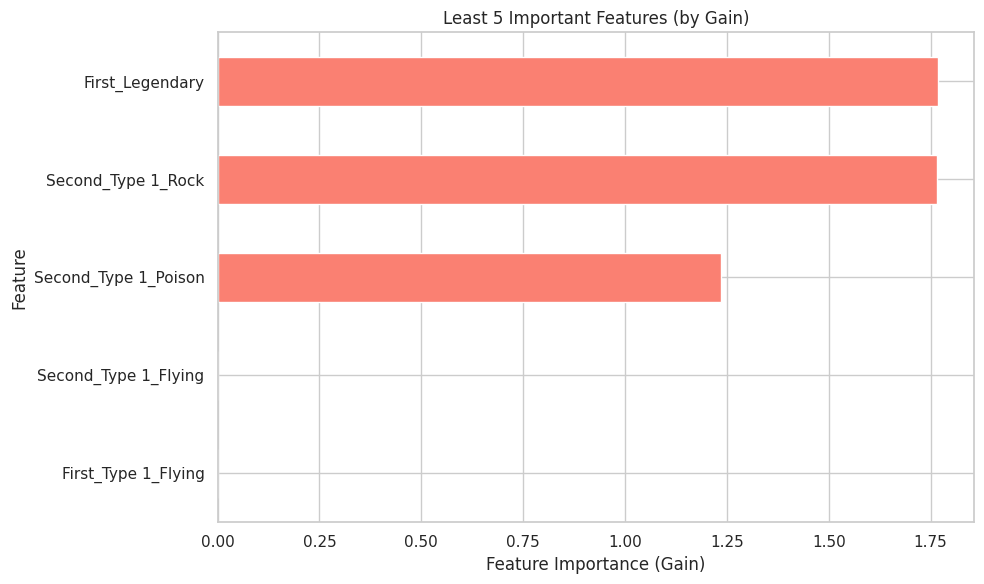

<Figure size 1200x800 with 0 Axes>

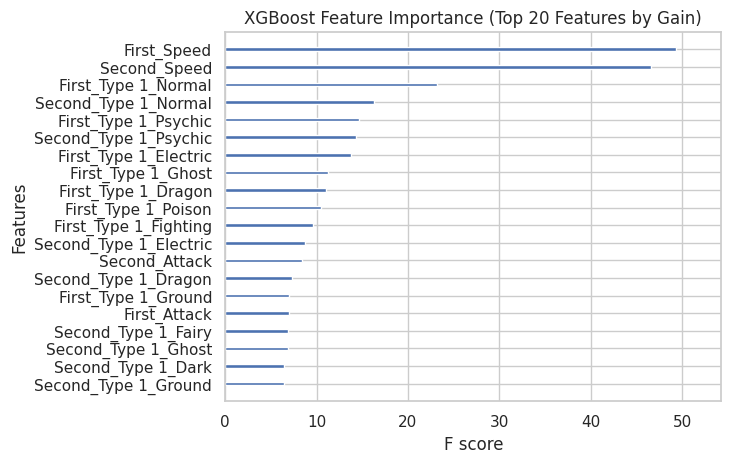

In [76]:

merged_pokemon_exp0=merged_pokemon.copy()

features = [
    'First_HP', 'First_Attack', 'First_Defense', 'First_Sp. Atk', 'First_Sp. Def', 'First_Speed',
    'Second_HP', 'Second_Attack', 'Second_Defense', 'Second_Sp. Atk', 'Second_Sp. Def', 'Second_Speed',
    'First_Generation', 'Second_Generation', 'First_Legendary', 'Second_Legendary',
    'First_Type 1', 'Second_Type 1'
]


model_exp0=train_xgboost_model(merged_df=merged_pokemon_exp0, feature_list=features,top_n=5)



## 🧪 Experiment 1: Removing the 'Generation' Feature

Based on our earlier deductions, we hypothesized that the **'Generation'** feature might not significantly impact model performance. To test this, we removed the feature and retrained the model.

### 📉 Observations:
- **Validation Accuracy** dropped slightly from `0.9618` to `0.9604`

This minor decrease is likely due to **validation set variability** rather than a meaningful performance loss. It supports our assumption that the 'Generation' feature does **not contribute significantly**.

### ➕ Decision:
Even though we might be justified in removing it, I’ve decided to **keep the 'Generation' feature** for now. Since our goal is to **maximize validation accuracy methodically**, retaining potentially useful features—even marginal ones—could prove beneficial as we layer in more complex engineering strategies.


Validation Accuracy: 0.9604

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.96      5280
           1       0.95      0.96      0.96      4720

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



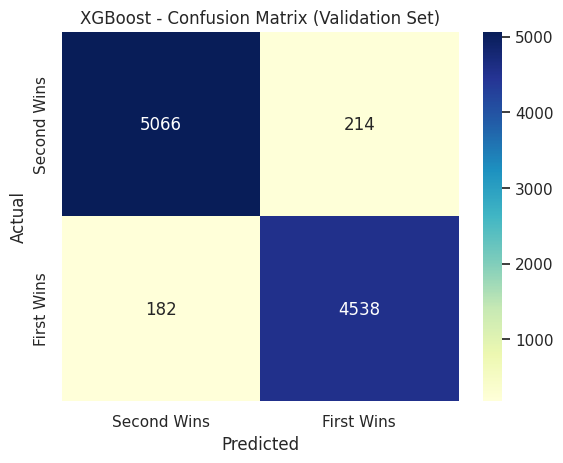

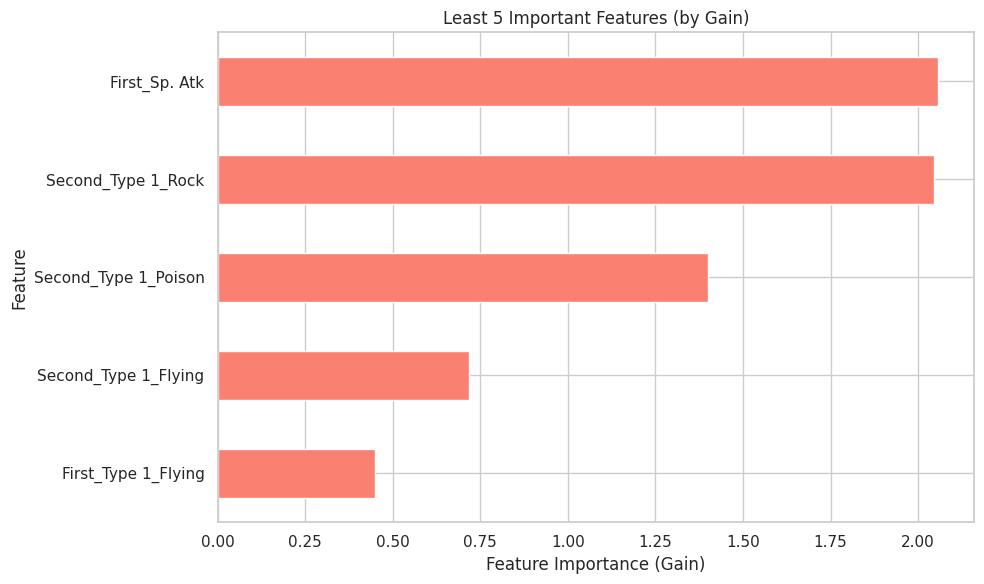

<Figure size 1200x800 with 0 Axes>

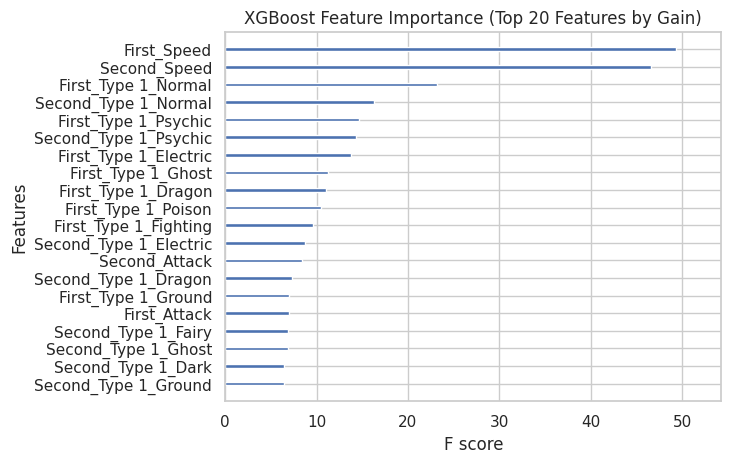

In [77]:
## Remove generation info

merged_pokemon_exp1=merged_pokemon.copy()
features = [
    'First_HP', 'First_Attack', 'First_Defense', 'First_Sp. Atk', 'First_Sp. Def', 'First_Speed',
    'Second_HP', 'Second_Attack', 'Second_Defense', 'Second_Sp. Atk', 'Second_Sp. Def', 'Second_Speed',
    'First_Legendary', 'Second_Legendary',
    'First_Type 1', 'Second_Type 1'
]


model_exp1=train_xgboost_model(merged_df=merged_pokemon_exp1, feature_list=features,top_n=5)



## 🧪 Experiment 2: Adding 'Difference' Features

In this experiment, we introduced **'difference'** features directly into the model. By explicitly providing these relationships between variables, we allow the trees to focus on learning more complex patterns instead of having to figure out these differences on their own.

### 📈 Observations:
- **Validation Accuracy** increased to `0.9637`
- **F1-Score** also rose to `0.9637`

This improvement indicates that directly providing these **difference features** helps the model capture relationships more effectively, enhancing its overall performance. It suggests that encoding such relationships upfront may be a valuable strategy in future feature engineering efforts.


Validation Accuracy: 0.9637

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.97      5280
           1       0.96      0.96      0.96      4720

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



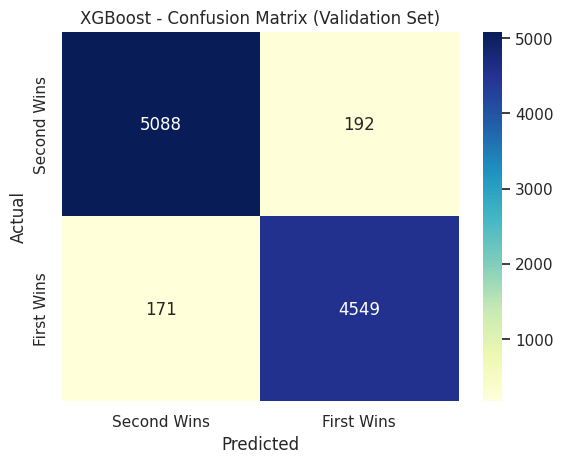

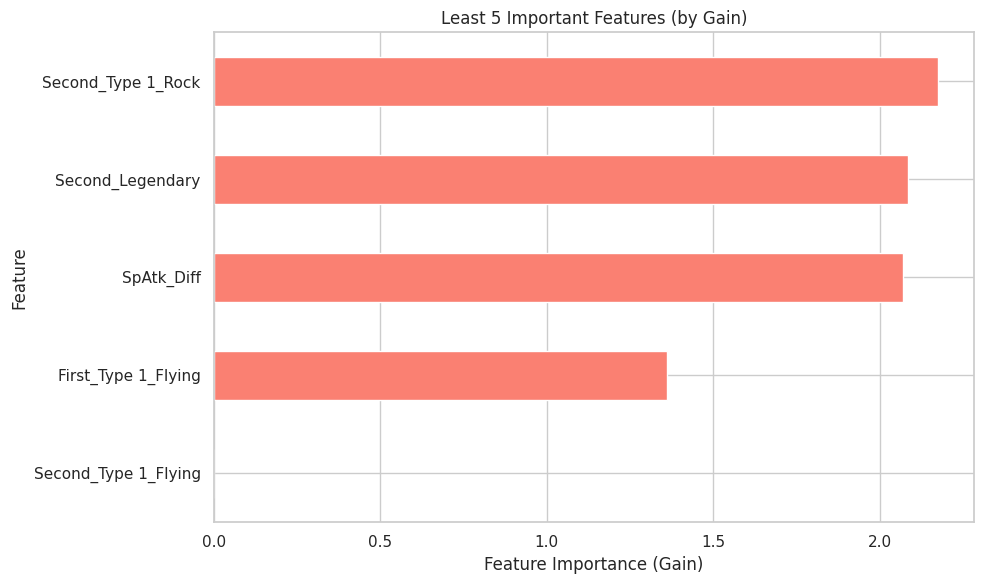

<Figure size 1200x800 with 0 Axes>

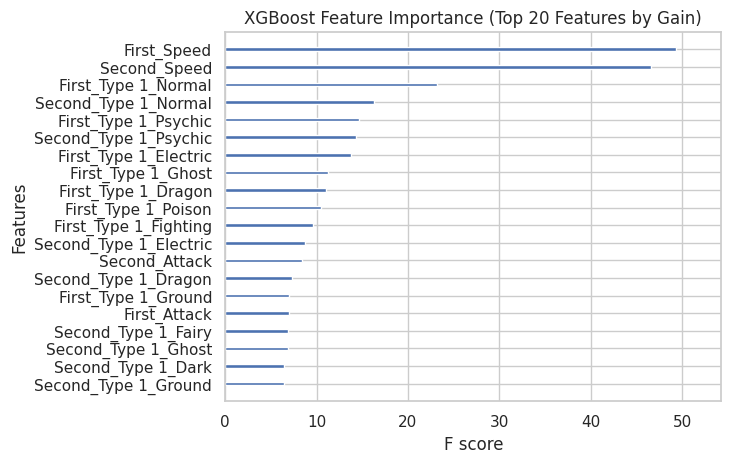

In [78]:
merged_pokemon_exp2 = merged_pokemon.copy()

merged_pokemon_exp2['HP_Diff'] = merged_pokemon_exp2['First_HP'] - merged_pokemon_exp2['Second_HP']
merged_pokemon_exp2['Attack_Diff'] = merged_pokemon_exp2['First_Attack'] - merged_pokemon_exp2['Second_Attack']
merged_pokemon_exp2['Defense_Diff'] = merged_pokemon_exp2['First_Defense'] - merged_pokemon_exp2['Second_Defense']
merged_pokemon_exp2['SpAtk_Diff'] = merged_pokemon_exp2['First_Sp. Atk'] - merged_pokemon_exp2['Second_Sp. Atk']
merged_pokemon_exp2['SpDef_Diff'] = merged_pokemon_exp2['First_Sp. Def'] - merged_pokemon_exp2['Second_Sp. Def']
merged_pokemon_exp2['Speed_Diff'] = merged_pokemon_exp2['First_Speed'] - merged_pokemon_exp2['Second_Speed']




features = [
    'First_HP', 'First_Attack', 'First_Defense', 'First_Sp. Atk', 'First_Sp. Def', 'First_Speed',
    'Second_HP', 'Second_Attack', 'Second_Defense', 'Second_Sp. Atk', 'Second_Sp. Def', 'Second_Speed',
    'First_Generation', 'Second_Generation', 'First_Legendary', 'Second_Legendary',
    'First_Type 1', 'Second_Type 1',
    'HP_Diff', 'Attack_Diff', 'Defense_Diff',
    'SpAtk_Diff', 'SpDef_Diff', 'Speed_Diff'
]










model_exp2=train_xgboost_model(merged_df=merged_pokemon_exp2, feature_list=features,top_n=5)



## 🧪 Experiment 3: Removing Direct Statistics After Adding 'Difference' Features

In this experiment, we tested whether we could remove the **direct statistical features** (e.g., speed, altitude) now that we've added the **'difference'** features. The assumption was that the model could rely solely on the differences, potentially simplifying the feature set.

### 📉 Observations:
- **Validation Accuracy** decreased slightly
- **F1-Score** also showed a minor drop

These results suggest that the direct statistical features still carry **valuable information** that the 'difference' features alone cannot fully capture. Therefore, we will **retain the direct statistics** in our model, as their presence helps maintain better performance.



Validation Accuracy: 0.9617

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.96      5280
           1       0.95      0.97      0.96      4720

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



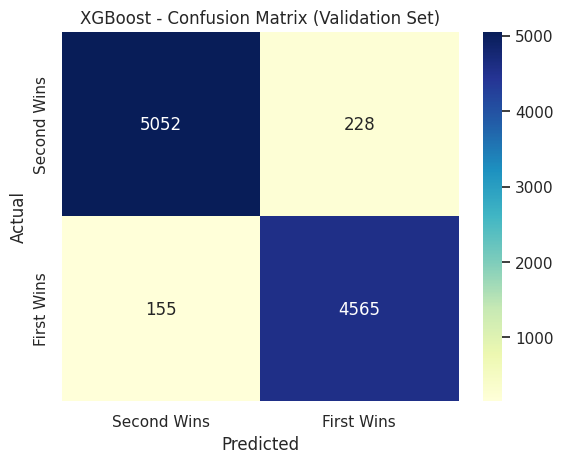

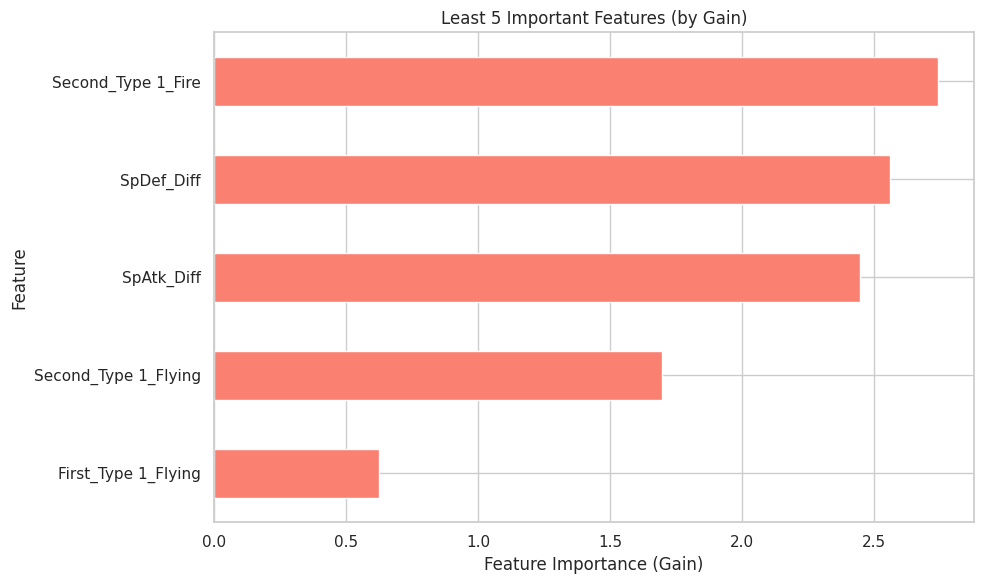

<Figure size 1200x800 with 0 Axes>

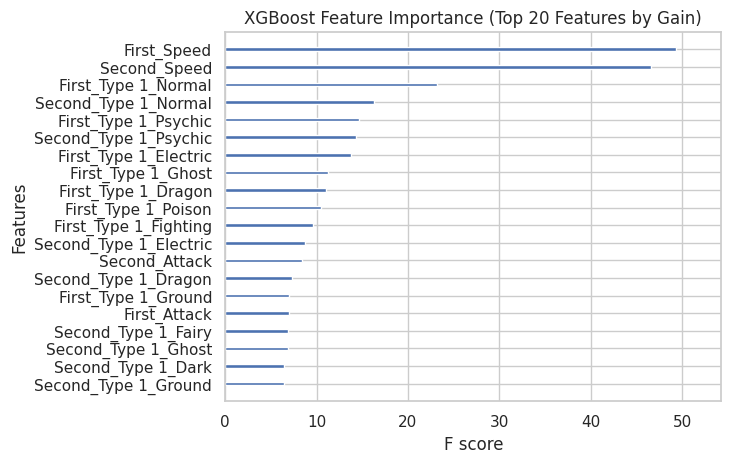

In [79]:
merged_pokemon_exp3=merged_pokemon_exp2.copy()
features_exp2_2 = [
    'First_Generation', 'Second_Generation',
    'First_Legendary', 'Second_Legendary',
    'First_Type 1', 'Second_Type 1',
    'HP_Diff', 'Attack_Diff', 'Defense_Diff',
    'SpAtk_Diff', 'SpDef_Diff', 'Speed_Diff'
]


model_exp2=train_xgboost_model(merged_df=merged_pokemon_exp3, feature_list=features_exp2_2,top_n=5)

## 🧪 Experiment 4: Handling Legendary Imbalance in Data

In this experiment, we explore whether we can directly add a feature indicating the presence of **legendary imbalance** in the combat. The idea is that by explicitly capturing this imbalance, we might help the model learn more effectively by emphasizing or de-emphasizing certain patterns.

### 💡 Hypothesis:
Introducing a feature that identifies areas of **legendary imbalance** could potentially guide the model to adjust its predictions, thereby improving overall performance.

### 📉 Observations:
- The addition of the legendary imbalance feature **reduced both the F1 score and validation accuracy** slightly.

Given these results, we have decided to **discard this feature** for now. Instead, we will proceed with **Experiment 2** (where we added 'difference' features) as the foundation for further **hyperparameter tuning**.


Validation Accuracy: 0.9623

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.96      5280
           1       0.95      0.97      0.96      4720

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



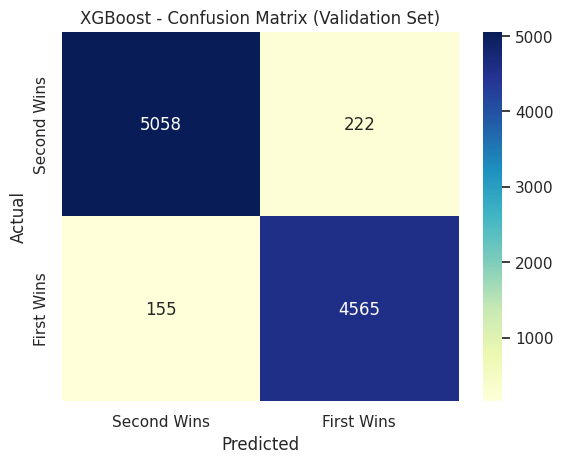

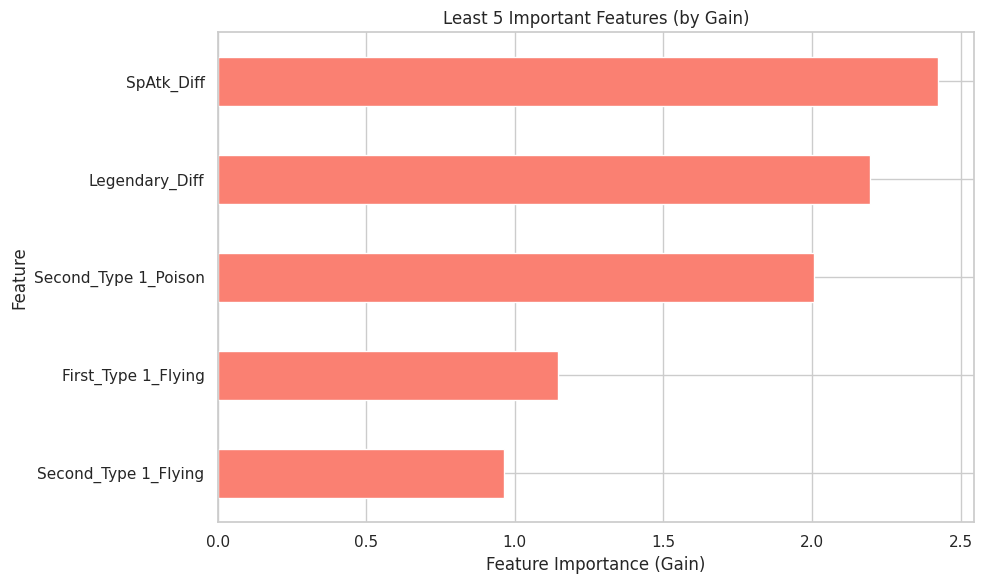

<Figure size 1200x800 with 0 Axes>

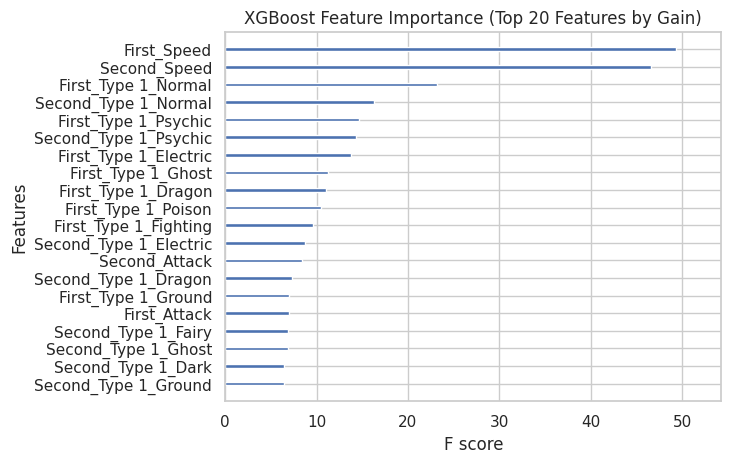

In [80]:
merged_pokemon_exp4=merged_pokemon_exp2.copy()



merged_pokemon_exp4['Legendary_Diff'] = merged_pokemon_exp4['First_Legendary'].astype(int) - merged_pokemon_exp4['Second_Legendary'].astype(int)
#merged_pokemon_exp4.to_csv('merged_pokemon_exp4.csv', index=False)

features_exp4 = [
    'First_Generation', 'Second_Generation',
    'First_Legendary', 'Second_Legendary',
    'First_Type 1', 'Second_Type 1',
    'HP_Diff', 'Attack_Diff', 'Defense_Diff',
    'SpAtk_Diff', 'SpDef_Diff', 'Speed_Diff','Legendary_Diff'
]


model_exp4=train_xgboost_model(merged_df=merged_pokemon_exp4, feature_list=features_exp4,top_n=5)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}
Best Cross-Validation Accuracy: 0.96685

Test Accuracy: 0.9646

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.97      5280
           1       0.96      0.96      0.96      4720

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



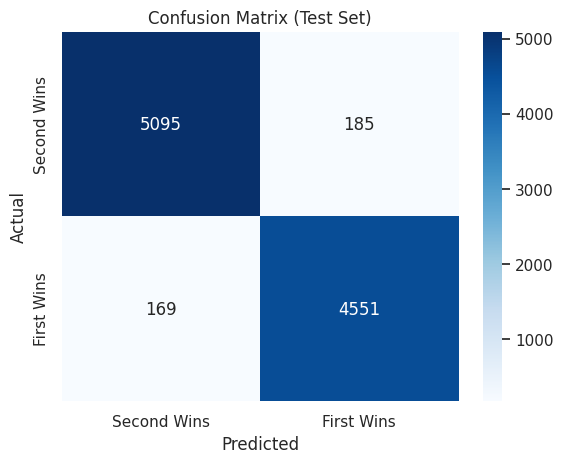

In [81]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def tune_xgboost_hyperparameters(merged_df, feature_list):
    """
    Performs hyperparameter tuning using GridSearchCV on an XGBoost classifier with GPU support.
    
    Parameters:
        merged_df (pd.DataFrame): The merged dataset containing all features and 'Winner'.
        feature_list (list): List of feature column names to include.

    Returns:
        best_model (XGBClassifier): The best estimator found by grid search.
    """
    # --- Prepare data ---
    df_model = merged_df[feature_list + ['Winner']].copy()

    # One-hot encode categorical variables
    df_model = pd.get_dummies(df_model, columns=['First_Type 1', 'Second_Type 1'], drop_first=True)

    X = df_model.drop('Winner', axis=1)
    y = df_model['Winner']

    # --- Split dataset ---
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # --- XGBoost with GPU ---
    xgb_clf = xgb.XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        tree_method='gpu_hist',
        predictor='gpu_predictor',
        verbosity=0
    )

    # --- Grid search params ---
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    grid_search = GridSearchCV(
        estimator=xgb_clf,
        param_grid=param_grid,
        scoring='accuracy',
        n_jobs=-1,
        cv=cv,
        verbose=1
    )

    grid_search.fit(X_train, y_train)

    print("Best Parameters:", grid_search.best_params_)
    print("Best Cross-Validation Accuracy:", grid_search.best_score_)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Second Wins', 'First Wins'],
                yticklabels=['Second Wins', 'First Wins'])
    plt.title("Confusion Matrix (Test Set)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return best_model

features = [
    'First_HP', 'First_Attack', 'First_Defense', 'First_Sp. Atk', 'First_Sp. Def', 'First_Speed',
    'Second_HP', 'Second_Attack', 'Second_Defense', 'Second_Sp. Atk', 'Second_Sp. Def', 'Second_Speed',
    'First_Generation', 'Second_Generation', 'First_Legendary', 'Second_Legendary',
    'First_Type 1', 'Second_Type 1',
    'HP_Diff', 'Attack_Diff', 'Defense_Diff',
    'SpAtk_Diff', 'SpDef_Diff', 'Speed_Diff'
]



best_model=tune_xgboost_hyperparameters(merged_pokemon_exp2,feature_list=features)

In [82]:
import pickle

# Save model
with open('best_model_exp2.pkl', 'wb') as f:
    pickle.dump(best_model, f)